Git repo: [https://github.com/YarinBS/Lab094295_hw1](https://github.com/YarinBS/Lab094295_hw1)

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

pd.set_option('display.max_columns', None)

Reading data

In [3]:
data = []

train_path = f"/home/student/hw1/data/train"

for psv_file in tqdm(os.listdir(train_path)):
    df = pd.read_csv(f"{train_path}/{psv_file}", sep='|')
    data.append(df)

100%|████████████████████████████████████████████████| 20000/20000 [00:39<00:00, 510.29it/s]


In [4]:
print(f"There are {len(data)} patients in the train data")

There are 20000 patients in the train data


For each patient, we consider the following:
* If the patient is not diagnosed with Sepsis at all, we consider only the last row in its DF.
* Otherwise, if the patient is diagnosed with Sepsis, we consider the 1st row where `SepsisLabel = 1`, and we average all rows where `SpesisLabel = 0`.

This way, we create 3 DFs to analyze the data:
1. A DF containing the last rows of patients who were not diagnosed with Sepsis.
2. A DF containing the first rows where `SepsisLabel = 1` of patients who were diagnosed with Sepsis.
3. A DF containing the last rows where `SepsisLabel = 0` of patients who were diagnosed with Sepsis.

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  # Using pd.concat() is really slow; Appending instead

not_diagnosed_df = pd.DataFrame(columns=data[0].columns)
diagnosed_zeros = pd.DataFrame(columns=data[0].columns)
diagnosed_ones = pd.DataFrame(columns=data[0].columns)

for i, dataframe in tqdm(enumerate(data)):
    sepsis_df = dataframe[dataframe['SepsisLabel'] == 1]
    if sepsis_df.shape[0] != 0:  # If True, patients is diagnosed with Spesis
        min_sepsis_index = int(sepsis_df.idxmin()['SepsisLabel'])  # The label where the first 1 appears
        first_sepsis_occurence = dataframe.iloc[min_sepsis_index, :]  # The row of the first 1
        diagnosed_ones = diagnosed_ones.append(first_sepsis_occurence, ignore_index=True)
        max_pre_sepsis_index = min_sepsis_index - 1  # The label where the last 0 appears
        if max_pre_sepsis_index != -1:
            last_pre_sepsis_occurence = dataframe.iloc[max_pre_sepsis_index, :]  # The row of the last 0
            diagnosed_zeros = diagnosed_zeros.append(last_pre_sepsis_occurence, ignore_index=True)
    else:  # Patient is not diagnosed with Sepsis
        last_row = dataframe.iloc[dataframe.shape[0]-1, :]# The last row of the dataframe
        not_diagnosed_df = not_diagnosed_df.append(last_row, ignore_index=True)

not_diagnosed_df = not_diagnosed_df.drop(columns=['SepsisLabel'])
diagnosed_zeros = diagnosed_zeros.drop(columns=['SepsisLabel'])
diagnosed_ones = diagnosed_ones.drop(columns=['SepsisLabel'])

20000it [00:38, 525.30it/s]


Now we have 3 DataFrames to analyze. First, we `describe()` each DataFrame:

In [6]:
not_diagnosed_df.describe()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS
count,15543.000000,14658.000000,5269.000000,14032.000000,14684.000000,10751.000000,14513.000000,210.000000,323.000000,406.000000,556.000000,467.000000,324.000000,215.000000,126.000000,640.000000,126.000000,512.000000,444.000000,578.000000,15.000000,2152.000000,121.000000,673.000000,375.000000,925.000000,118.000000,88.000000,843.000000,701.000000,283.000000,598.000000,52.000000,562.000000,18585.000000,18585.000000,11537.000000,11537.000000,18585.000000,18585.000000
mean,83.574567,96.783906,36.949165,124.913258,83.173373,65.384196,19.010818,33.540476,0.087926,24.759360,0.503219,7.391627,41.637037,90.744651,240.753968,22.859375,105.769841,8.103418,105.181306,1.433114,1.245333,138.093285,2.880000,2.072660,3.390667,4.097568,2.236441,9.741250,30.116548,10.159629,46.268763,10.824849,315.432692,190.078292,61.623673,0.553565,0.486695,0.513305,-49.169890,37.301157
std,16.178556,3.450142,0.699160,22.607749,16.440256,13.946502,4.769112,9.222633,4.692912,4.408465,0.186207,0.084054,10.436587,12.331627,613.123762,18.188258,107.029877,1.713828,6.013652,1.602417,2.023144,49.245543,3.435168,0.339943,1.642140,0.607691,3.980372,25.750997,5.147754,1.829476,31.908605,5.144586,163.454708,102.828449,16.478798,0.497136,0.499845,0.499845,135.771101,15.203533
min,25.000000,22.000000,31.330000,20.000000,24.500000,22.000000,1.000000,10.000000,-24.000000,11.000000,0.000000,6.780000,17.000000,47.000000,7.000000,1.000000,18.000000,1.000000,86.000000,0.300000,0.100000,41.000000,0.600000,1.100000,0.800000,2.400000,0.100000,0.010000,17.000000,5.100000,18.400000,0.200000,65.000000,24.000000,15.000000,0.000000,0.000000,0.000000,-5366.860000,8.000000
25%,72.000000,95.000000,36.500000,109.000000,72.000000,56.000000,16.000000,28.000000,-2.000000,22.250000,0.400000,7.360000,35.000000,92.850000,24.250000,11.000000,54.250000,7.900000,101.000000,0.700000,0.200000,107.000000,1.200000,1.900000,2.400000,3.700000,0.500000,0.070000,26.700000,8.900000,28.300000,7.700000,205.250000,114.250000,51.000000,0.000000,0.000000,0.000000,-41.290000,25.000000
50%,82.000000,97.000000,36.900000,123.000000,81.330000,64.000000,18.500000,34.000000,0.000000,25.000000,0.500000,7.400000,40.500000,96.000000,60.000000,17.000000,68.500000,8.400000,105.000000,0.930000,0.300000,128.000000,1.630000,2.000000,3.100000,4.000000,0.900000,0.345000,29.400000,10.000000,34.300000,9.850000,285.500000,174.000000,63.180000,1.000000,0.000000,1.000000,-6.090000,39.000000
75%,94.000000,99.000000,37.400000,139.000000,93.000000,74.000000,22.000000,39.000000,3.000000,27.000000,0.500000,7.440000,45.000000,98.000000,145.250000,27.000000,110.000000,8.800000,109.000000,1.447500,1.040000,154.000000,2.500000,2.200000,3.800000,4.300000,2.075000,5.675000,32.800000,11.200000,52.500000,13.075000,386.500000,241.750000,74.000000,1.000000,1.000000,1.000000,-0.050000,47.000000
max,168.000000,100.000000,50.000000,226.000000,298.000000,161.000000,95.000000,94.000000,12.000000,45.000000,1.000000,7.550000,88.000000,100.000000,4710.000000,125.000000,875.000000,18.800000,130.000000,12.600000,6.700000,475.000000,17.750000,4.400000,12.700000,9.800000,29.200000,200.000000,59.400000,18.800000,249.000000,50.200000,932.000000,654.000000,100.000000,1.000000,1.000000,1.000000,17.340000,336.000000


In [7]:
diagnosed_zeros.describe()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS
count,1125.000000,1093.000000,417.000000,1024.000000,1102.000000,855.000000,1055.000000,103.000000,103.000000,67.000000,186.000000,124.000000,95.000000,52.00000,32.000000,98.000000,31.000000,87.000000,74.000000,85.000000,3.000000,199.000000,55.000000,98.000000,59.000000,136.000000,25.000000,15.000000,123.000000,105.000000,48.00000,90.000000,10.000000,80.000000,1217.000000,1217.000000,652.000000,652.000000,1217.000000,1217.000000
mean,89.741333,97.065874,37.243333,122.658691,80.729809,62.616959,20.349289,33.189320,0.620874,23.660448,0.522312,7.395081,42.038947,94.11250,396.156250,32.867347,86.612903,7.455977,106.743243,1.742235,0.816667,136.213568,2.301091,2.068367,3.715254,4.117647,2.120000,6.210000,30.750407,10.366952,41.72500,13.454444,289.400000,190.881250,62.273846,0.580115,0.578221,0.421779,-75.446376,57.506163
std,19.036097,2.921165,0.910396,24.672636,16.128257,14.353120,5.943533,7.043672,4.718391,5.620320,0.181907,0.071323,10.046459,7.13109,931.815713,22.593968,41.548909,2.172349,6.666335,1.692016,1.111680,44.478554,1.545615,0.402722,1.509146,0.695289,4.430199,14.613879,5.366466,1.821113,28.54794,9.699336,181.904248,113.865239,16.635217,0.493743,0.494223,0.494223,189.091841,59.958073
min,44.000000,77.000000,33.400000,63.000000,20.000000,23.000000,1.500000,16.000000,-9.000000,12.000000,0.210000,7.150000,24.000000,63.00000,14.000000,5.000000,36.000000,1.090000,91.000000,0.300000,0.150000,47.500000,0.500000,1.000000,2.000000,2.100000,0.100000,0.010000,18.000000,6.400000,20.00000,0.100000,123.000000,18.000000,18.000000,0.000000,0.000000,0.000000,-2668.770000,1.000000
25%,76.000000,95.000000,36.670000,104.000000,70.000000,53.000000,16.000000,28.000000,-2.000000,19.500000,0.400000,7.370000,36.000000,93.75000,23.000000,15.000000,56.500000,7.600000,102.250000,0.700000,0.175000,105.000000,1.300000,1.800000,2.800000,3.700000,0.500000,0.295000,26.900000,8.900000,28.05000,8.225000,163.000000,115.500000,51.970000,0.000000,0.000000,0.000000,-62.830000,13.000000
50%,89.000000,98.000000,37.280000,119.000000,79.330000,61.000000,20.000000,34.000000,0.000000,24.000000,0.500000,7.410000,40.500000,97.00000,45.500000,27.000000,78.000000,8.000000,107.000000,1.200000,0.200000,128.000000,1.900000,2.100000,3.200000,4.000000,0.700000,1.030000,30.950000,10.300000,32.20000,11.550000,190.500000,165.500000,64.790000,1.000000,1.000000,0.000000,-3.360000,37.000000
75%,102.000000,99.500000,37.890000,138.125000,90.917500,70.000000,24.000000,39.000000,3.000000,26.500000,0.600000,7.440000,47.000000,98.00000,203.500000,42.500000,114.000000,8.700000,112.000000,2.100000,1.150000,156.500000,3.050000,2.300000,4.250000,4.425000,1.400000,4.630000,34.000000,11.600000,43.15000,15.500000,395.000000,246.500000,74.400000,1.000000,1.000000,1.000000,-0.030000,81.000000
max,184.000000,100.000000,39.440000,220.000000,179.000000,175.000000,49.000000,50.000000,19.000000,43.000000,1.000000,7.530000,84.000000,99.60000,4433.000000,103.000000,219.000000,9.700000,120.000000,10.000000,2.100000,299.000000,9.600000,3.600000,9.300000,6.100000,20.700000,57.340000,43.000000,14.400000,150.00000,77.200000,673.000000,626.000000,100.000000,1.000000,1.000000,1.000000,16.020000,330.000000


In [8]:
diagnosed_ones.describe()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS
count,1155.000000,1125.000000,395.000000,1051.000000,1134.000000,874.000000,1078.000000,110.000000,94.000000,54.000000,187.000000,122.000000,96.000000,66.000000,16.000000,73.000000,15.000000,69.000000,64.000000,61.000000,3.000000,183.000000,63.000000,72.000000,44.000000,119.000000,14.000000,8.000000,91.000000,73.000000,50.0000,62.000000,12.000000,62.000000,1415.000000,1415.000000,777.000000,777.000000,1415.000000,1415.000000
mean,90.274892,96.983111,37.180506,122.864891,81.528554,62.902746,20.462199,32.772727,0.056383,23.966667,0.550481,7.378934,42.364583,92.836364,92.750000,26.219178,86.600000,6.852029,106.117188,1.600656,0.433333,141.203552,3.070952,2.073611,3.456818,4.177647,2.507143,29.421250,30.698352,10.492466,48.8590,12.885484,193.583333,179.435484,62.250940,0.580919,0.594595,0.405405,-74.686587,50.504594
std,18.946952,3.323014,0.936801,24.397715,16.850935,14.160019,5.845684,7.105895,4.564032,3.990933,0.206680,0.084617,9.850610,9.550093,93.709124,16.478308,66.771251,2.883458,5.445795,1.705200,0.321455,50.248325,3.384499,0.392534,1.297296,0.768465,4.533714,69.537754,5.303796,1.767446,28.7703,7.413033,60.382807,109.060612,16.574504,0.493583,0.491287,0.491287,186.126906,59.038631
min,42.000000,56.000000,32.900000,62.000000,33.000000,25.500000,3.000000,13.000000,-9.000000,15.000000,0.280000,7.080000,22.000000,61.000000,11.000000,2.000000,7.000000,1.090000,94.000000,0.430000,0.200000,59.000000,0.600000,1.200000,1.200000,2.000000,0.100000,0.030000,18.000000,6.600000,22.6000,0.100000,105.000000,19.000000,18.000000,0.000000,0.000000,0.000000,-2668.770000,1.000000
25%,77.000000,96.000000,36.600000,104.000000,70.000000,53.000000,16.000000,28.000000,-3.000000,22.000000,0.400000,7.330000,34.750000,94.025000,26.000000,15.000000,53.000000,7.200000,103.000000,0.800000,0.250000,109.000000,1.300000,1.800000,2.700000,3.700000,0.600000,0.195000,27.000000,9.300000,30.4250,8.100000,162.250000,112.250000,51.750000,0.000000,0.000000,0.000000,-62.820000,7.000000
50%,89.000000,98.000000,37.300000,120.000000,79.000000,61.500000,20.000000,33.000000,0.000000,24.000000,0.500000,7.400000,42.000000,96.000000,67.000000,21.000000,63.000000,8.100000,106.000000,1.100000,0.300000,133.000000,1.900000,2.000000,3.300000,4.000000,1.100000,0.325000,30.200000,10.300000,38.4500,11.400000,187.000000,156.500000,64.000000,1.000000,1.000000,0.000000,-2.740000,29.000000
75%,102.000000,99.500000,37.830000,138.125000,91.000000,71.000000,24.000000,37.750000,2.787500,26.000000,0.600000,7.430000,48.000000,98.000000,127.000000,35.000000,93.500000,8.600000,110.000000,1.900000,0.550000,159.000000,3.700000,2.225000,3.925000,4.600000,1.575000,12.447500,33.350000,11.400000,57.8500,15.550000,223.250000,227.250000,74.920000,1.000000,1.000000,1.000000,-0.020000,72.000000
max,200.000000,100.000000,39.700000,230.000000,250.000000,125.000000,49.000000,50.000000,16.000000,33.000000,1.000000,7.570000,79.200000,100.000000,370.000000,79.000000,269.000000,10.200000,118.000000,12.500000,0.800000,378.000000,21.000000,3.200000,8.300000,6.100000,17.700000,200.000000,44.500000,15.500000,150.0000,49.100000,296.000000,607.000000,100.000000,1.000000,1.000000,1.000000,16.020000,331.000000


Also creating Boxplots for each feature to visualize the above tables:

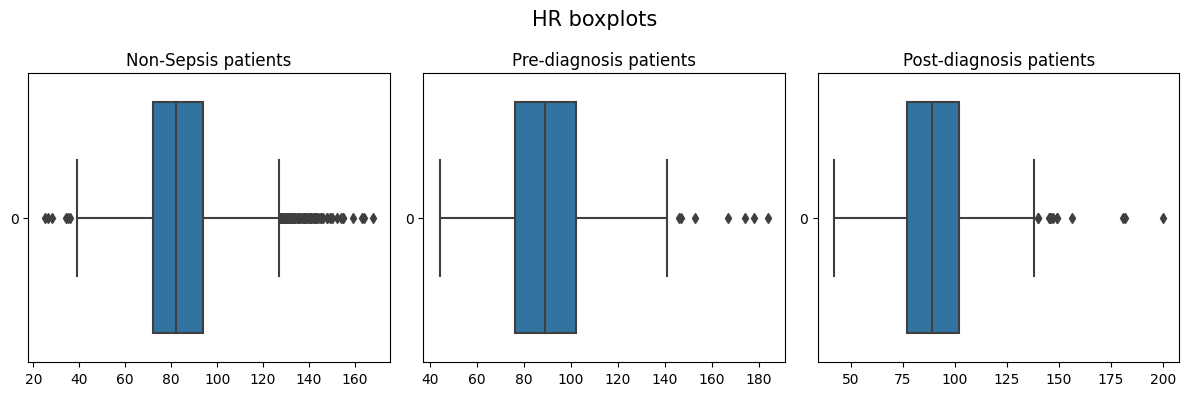

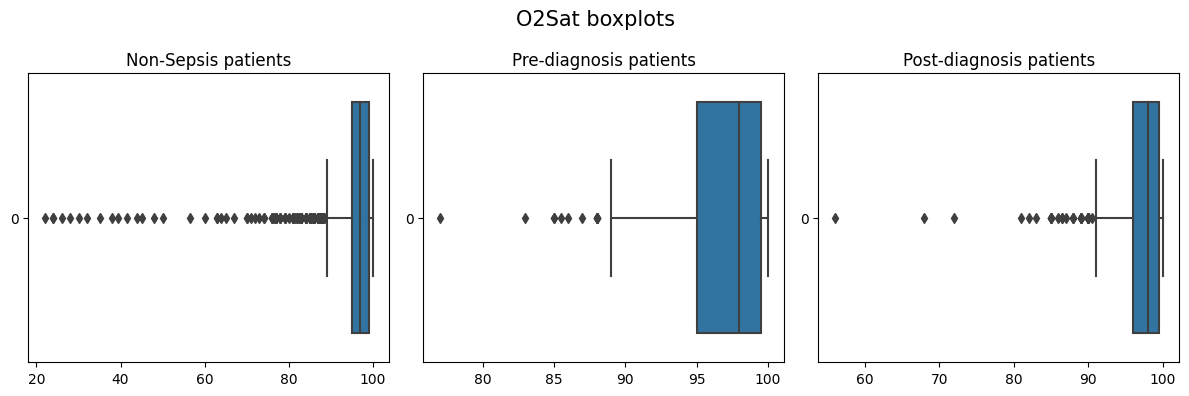

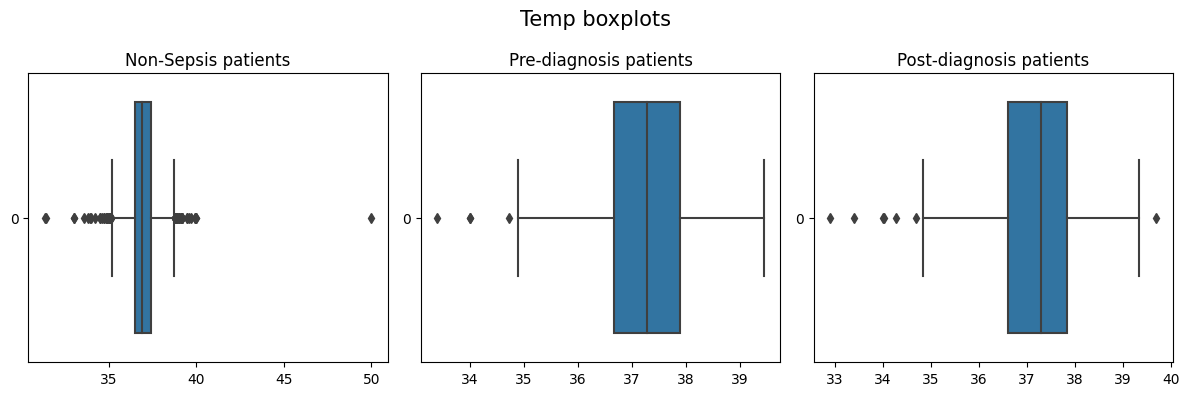

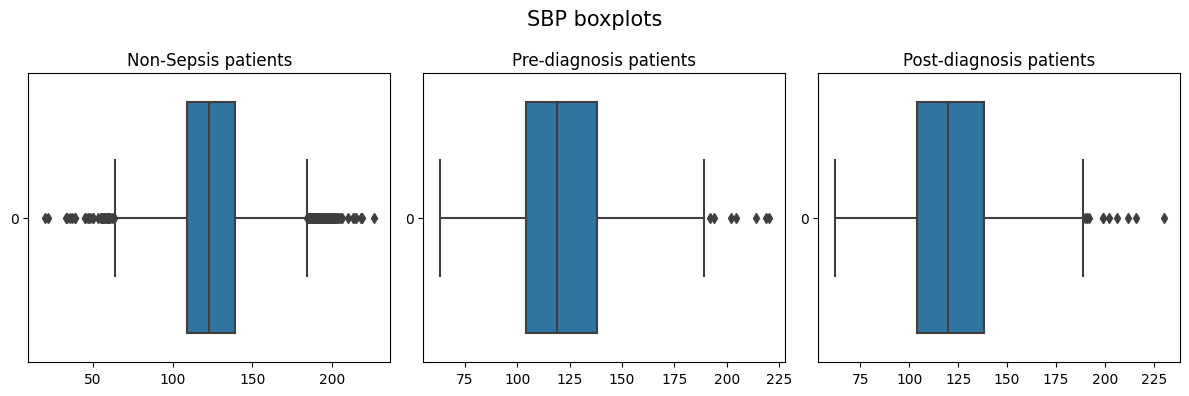

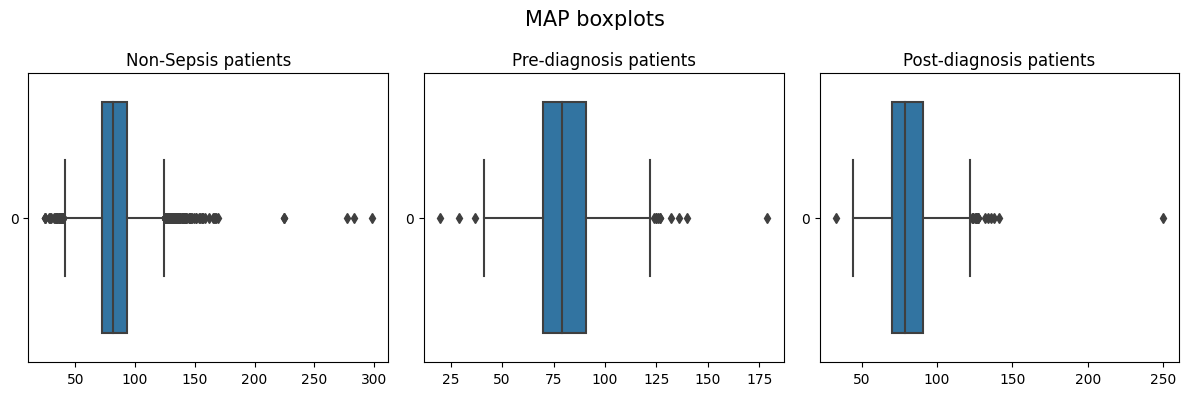

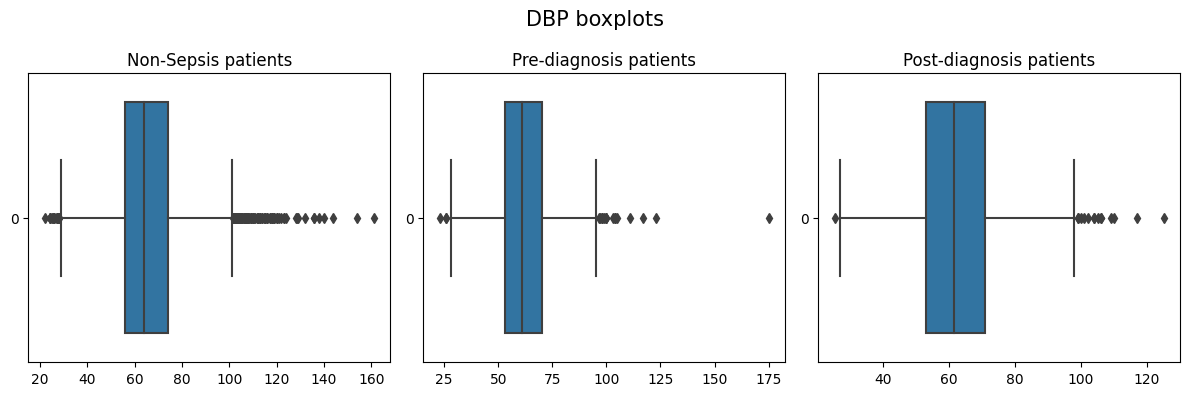

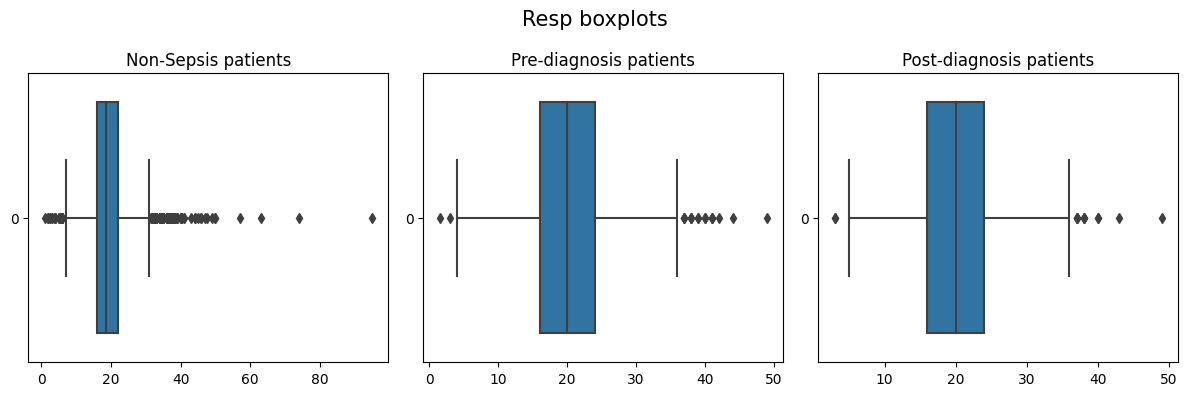

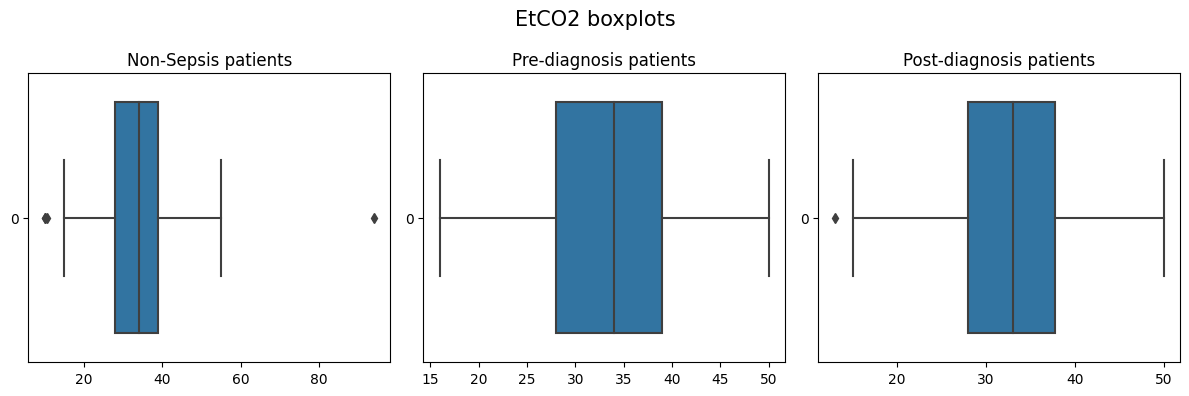

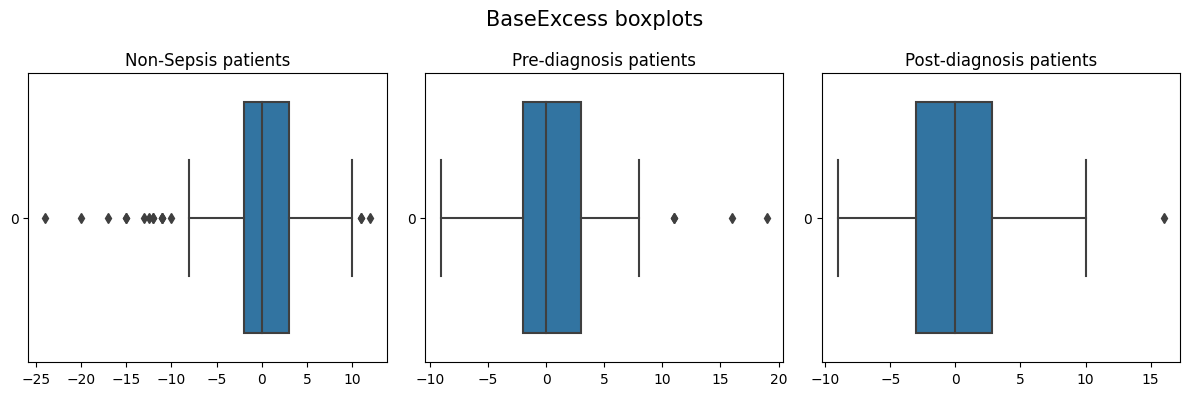

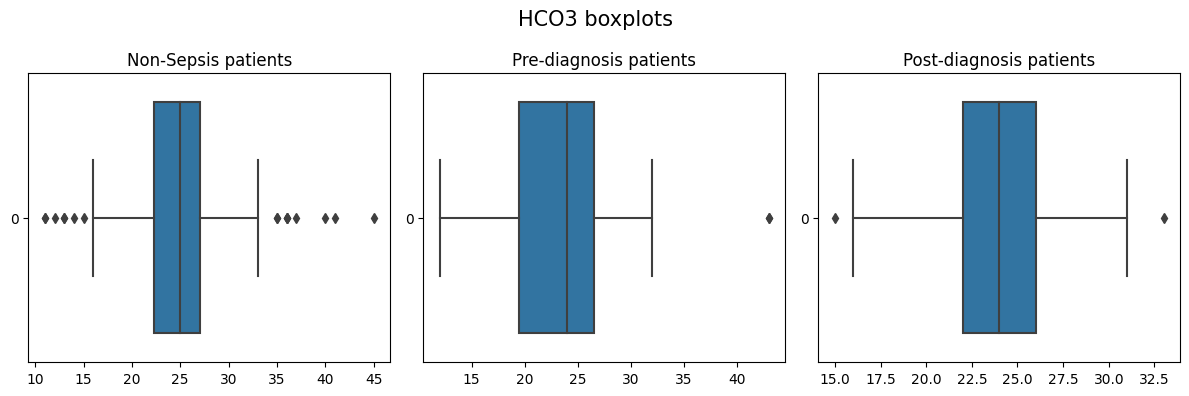

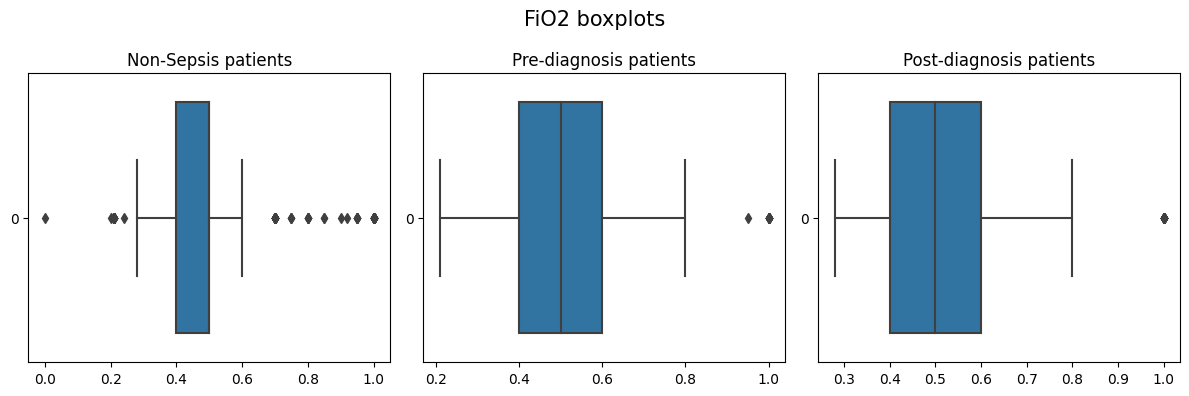

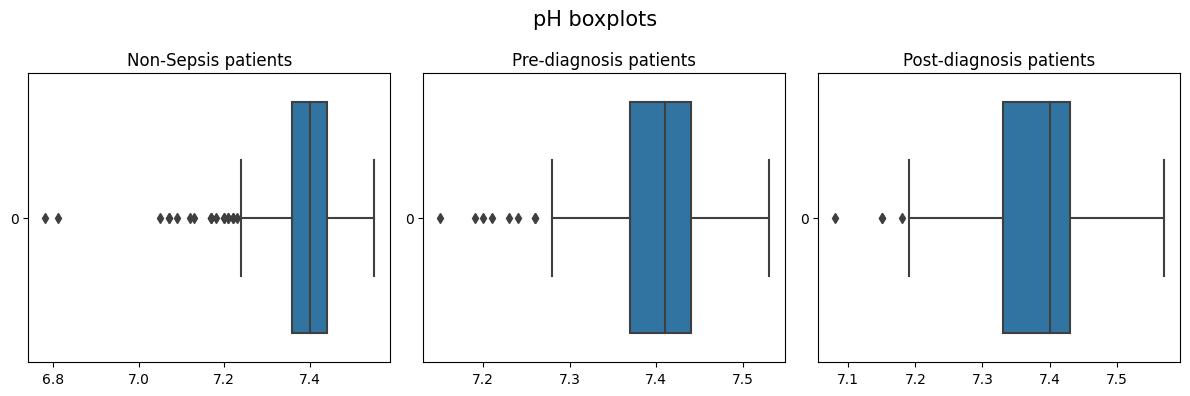

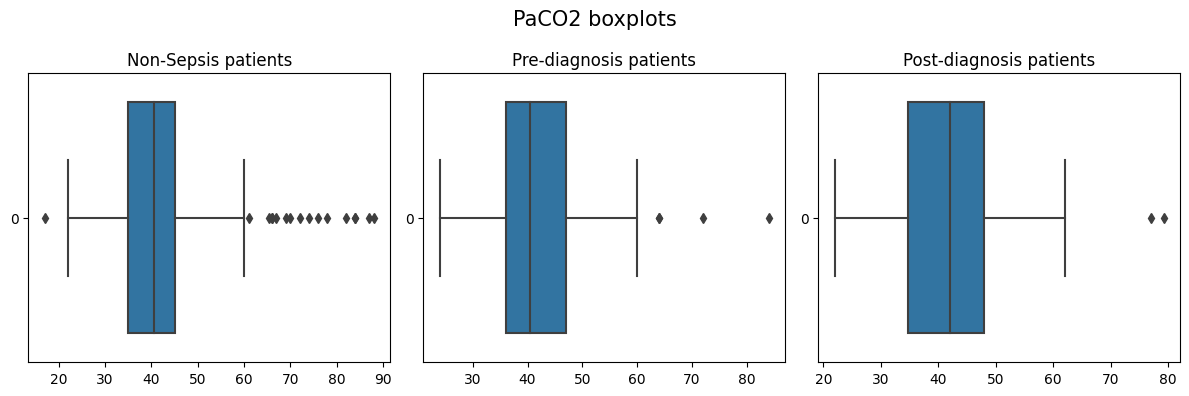

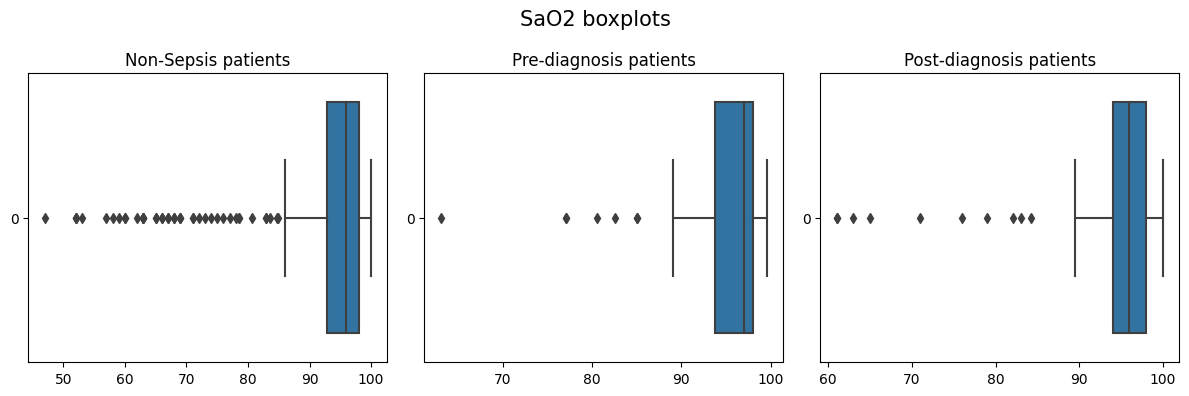

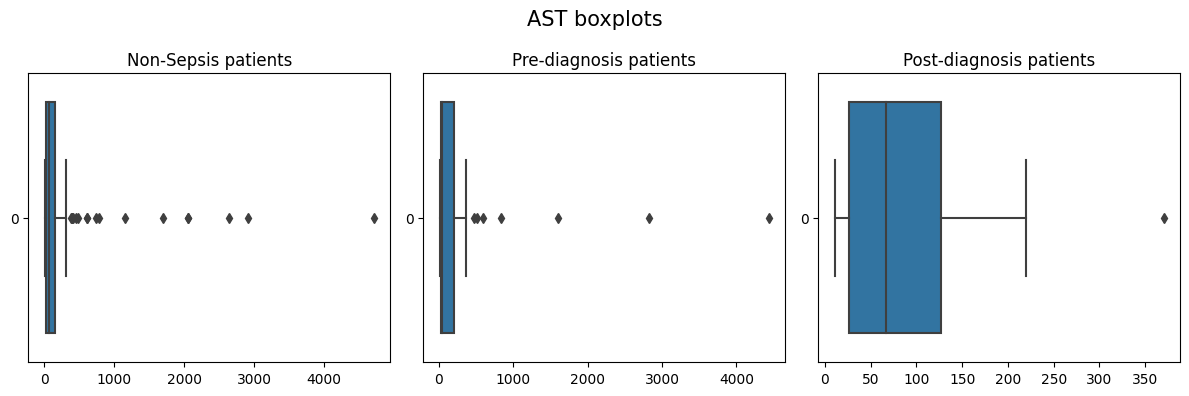

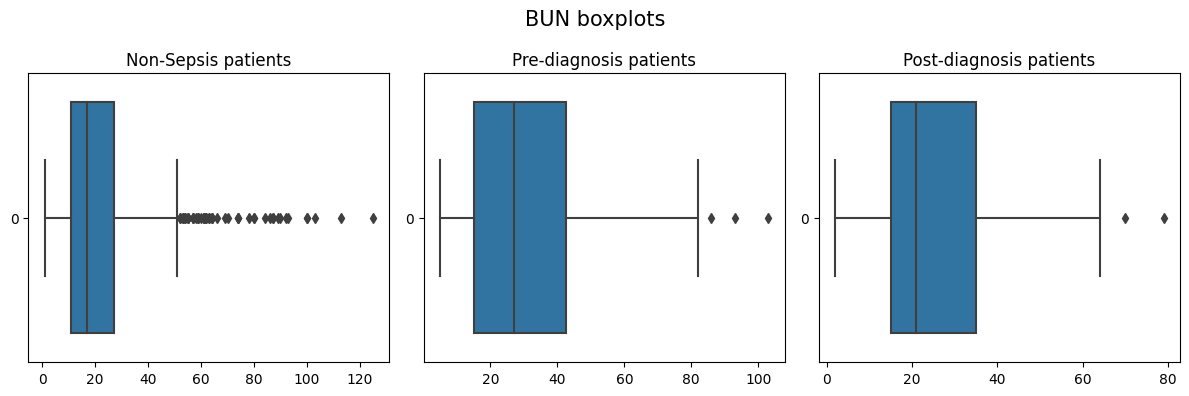

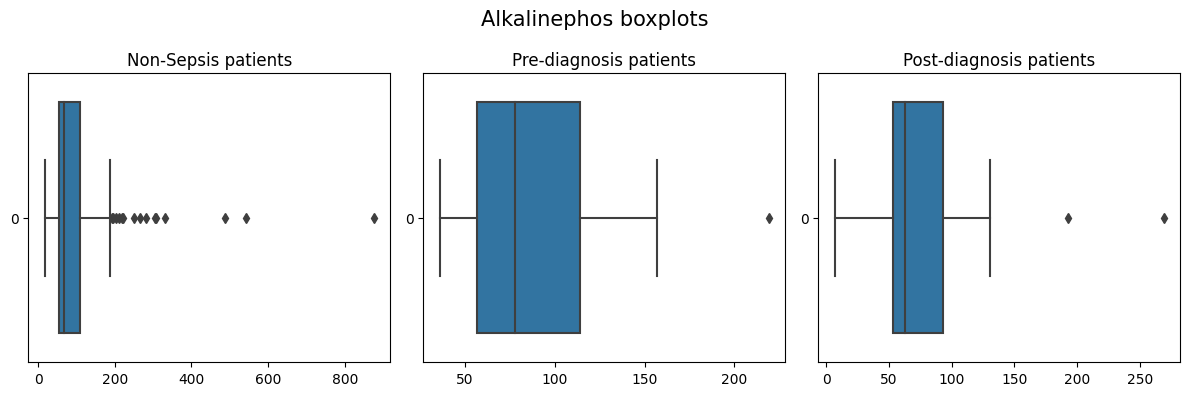

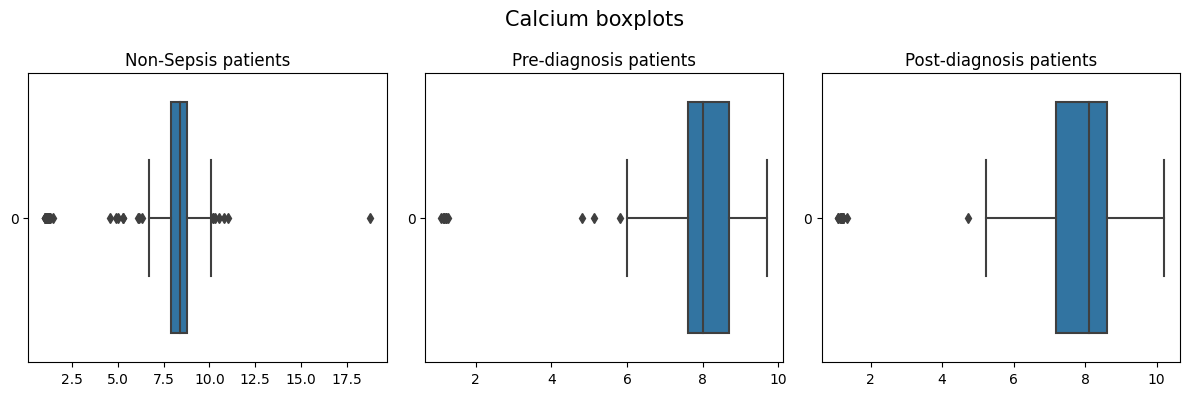

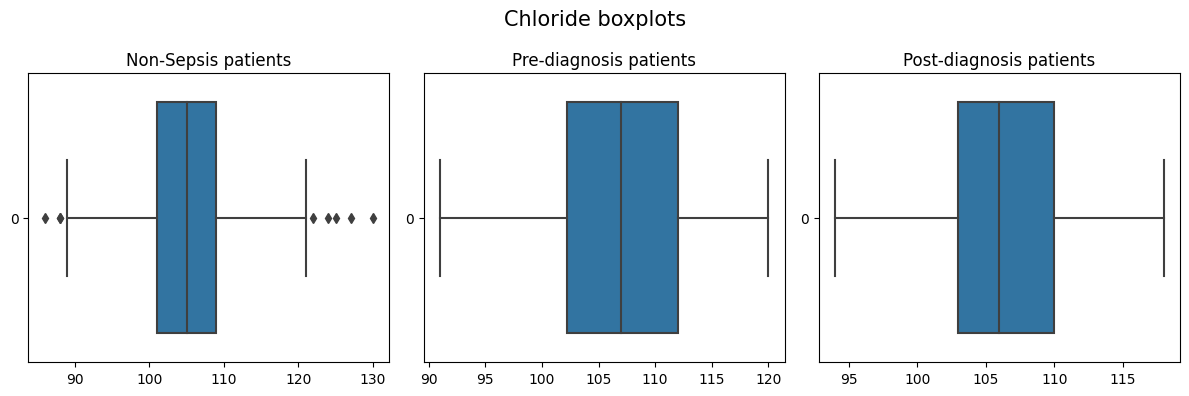

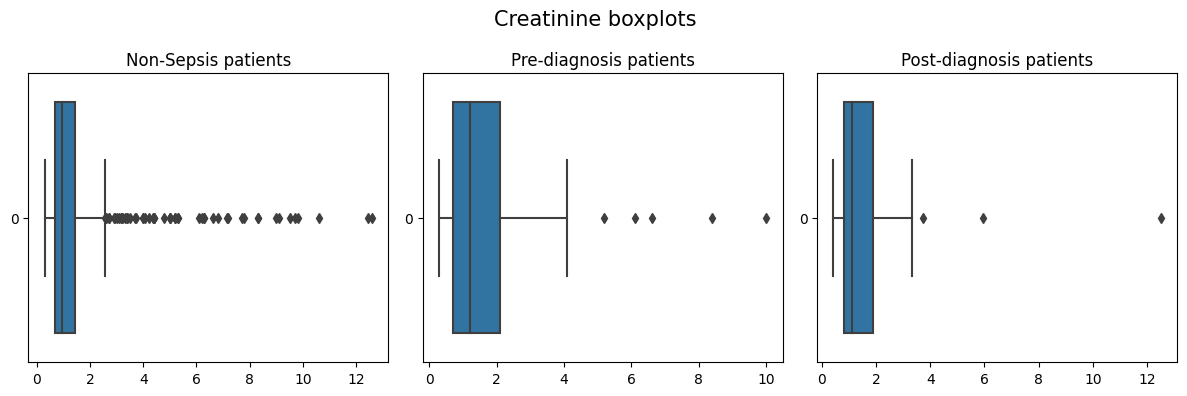

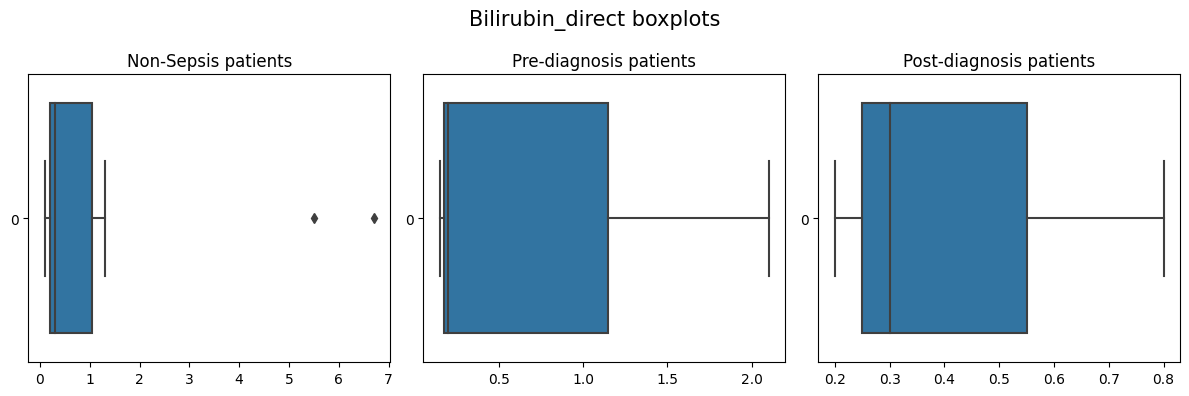

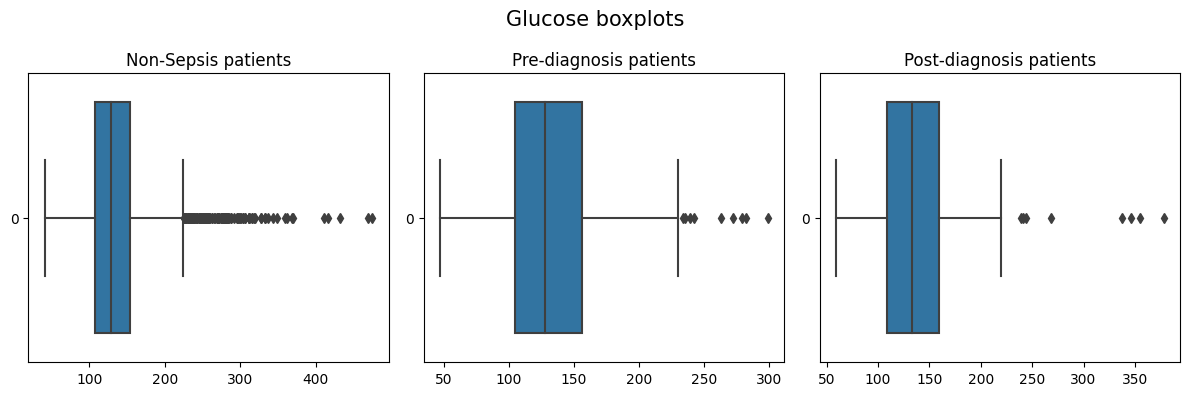

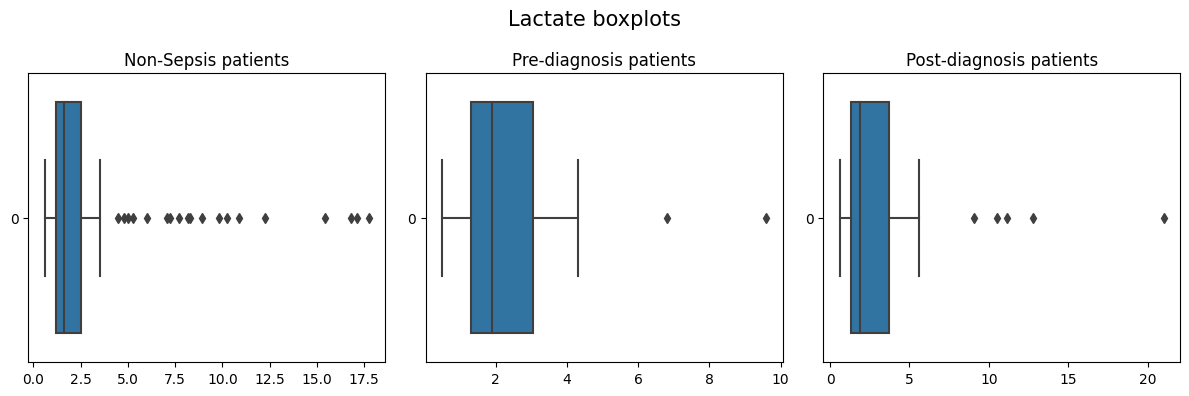

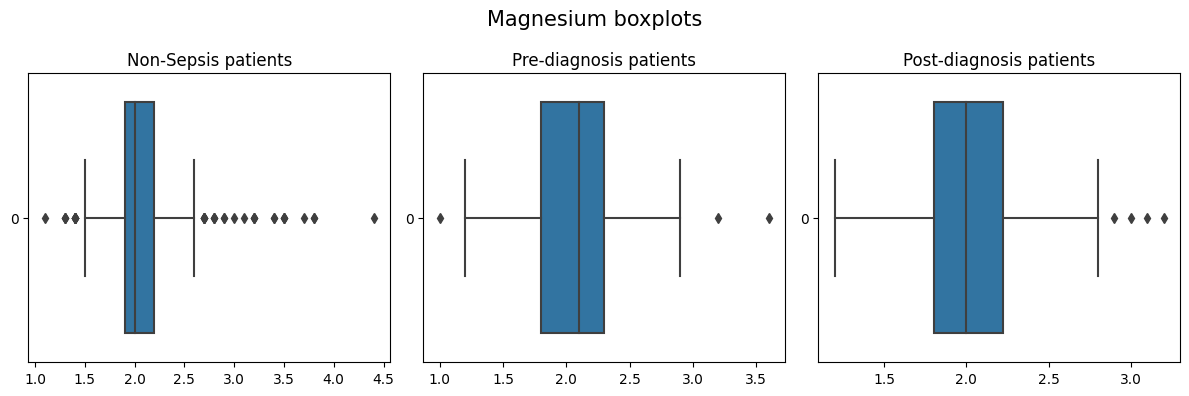

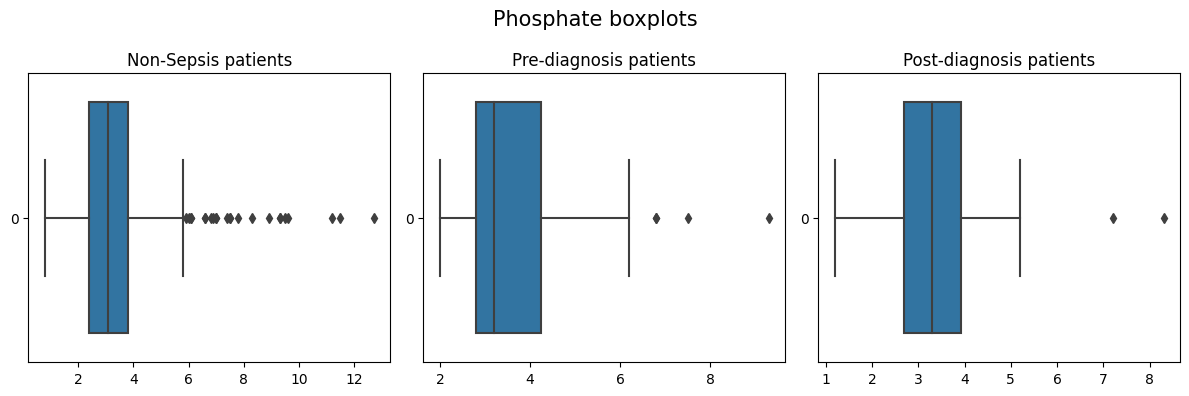

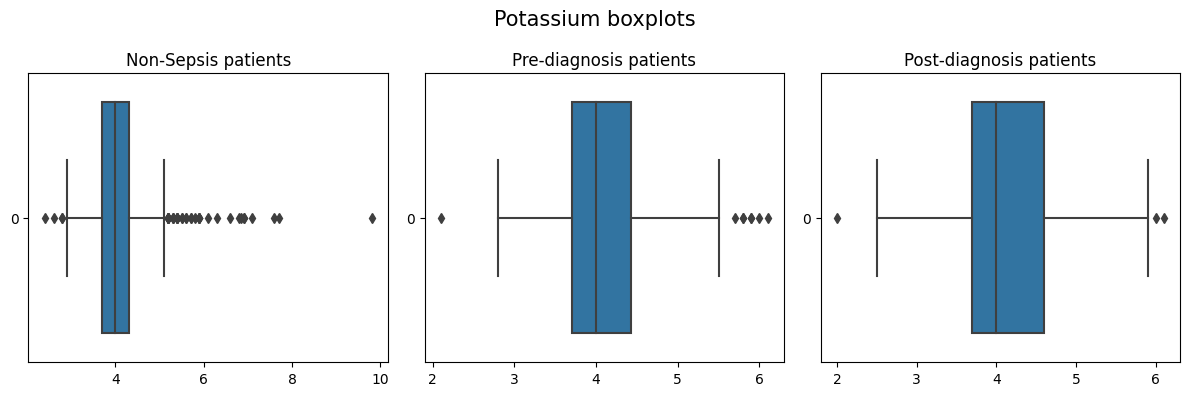

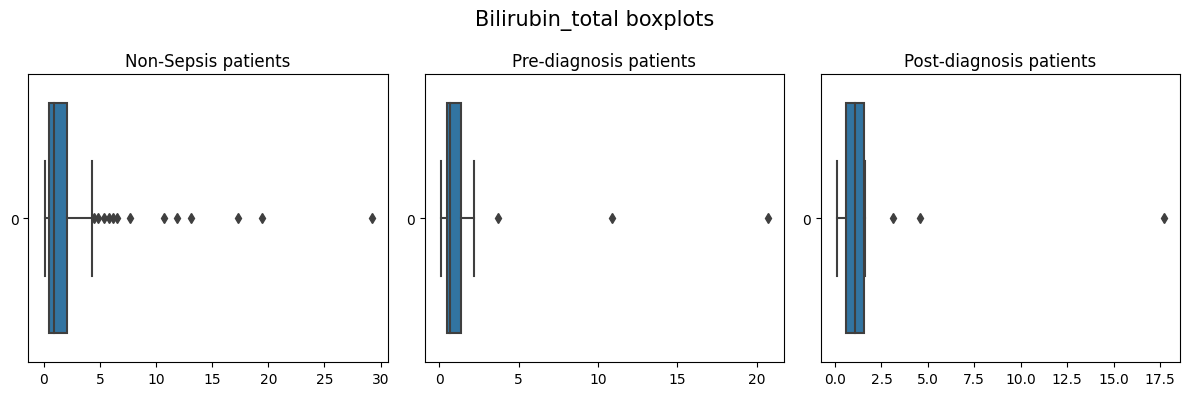

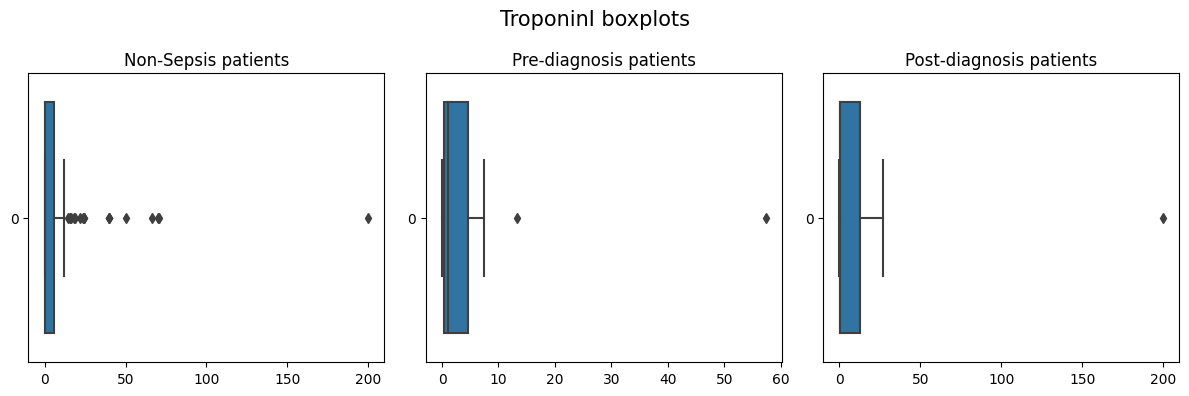

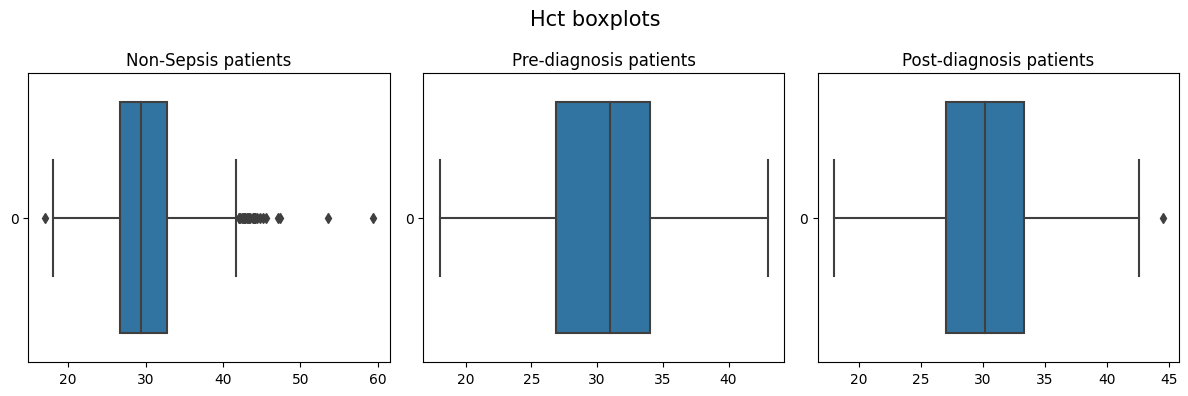

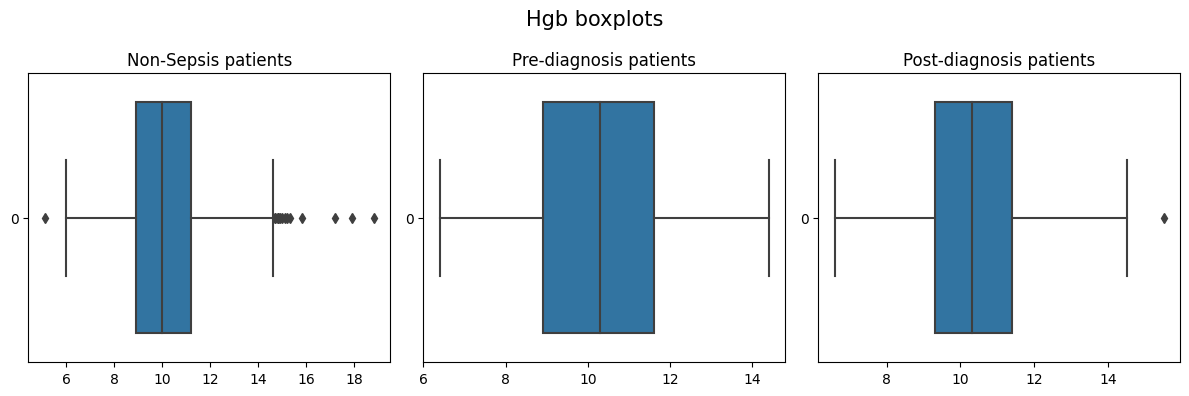

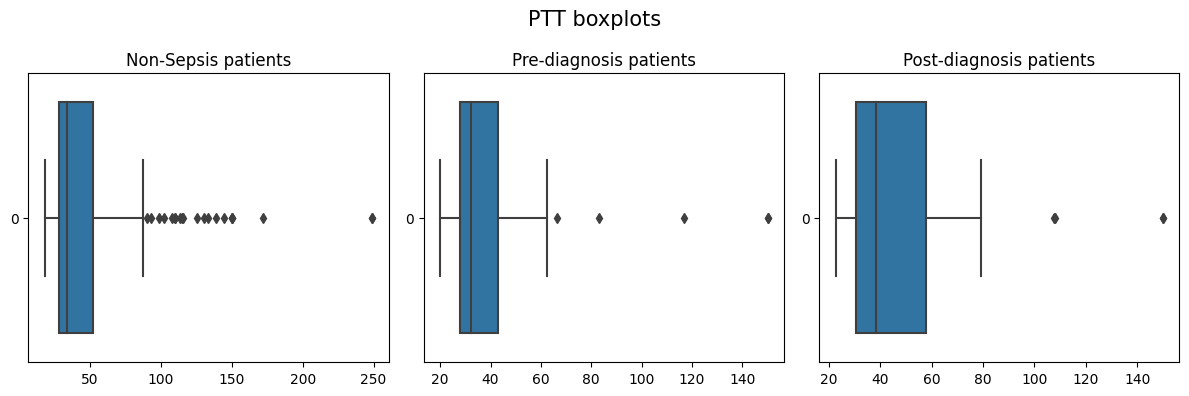

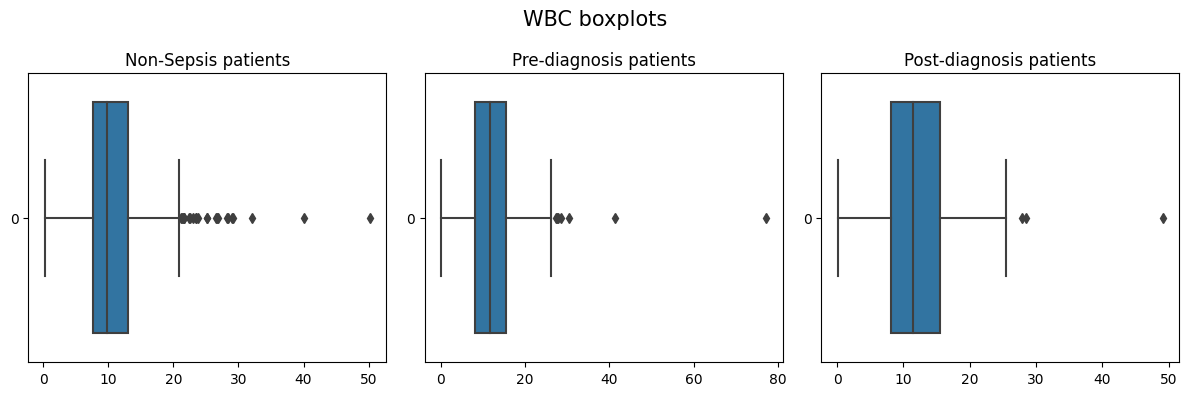

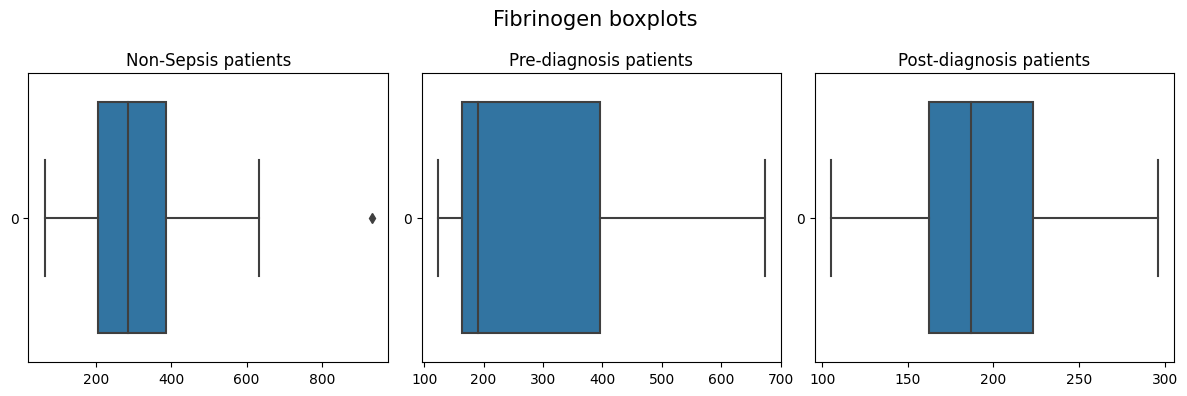

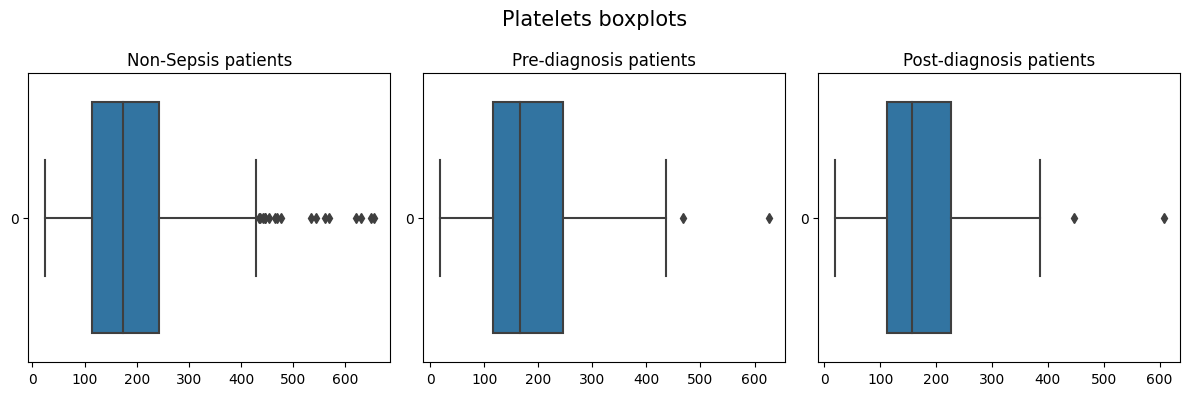

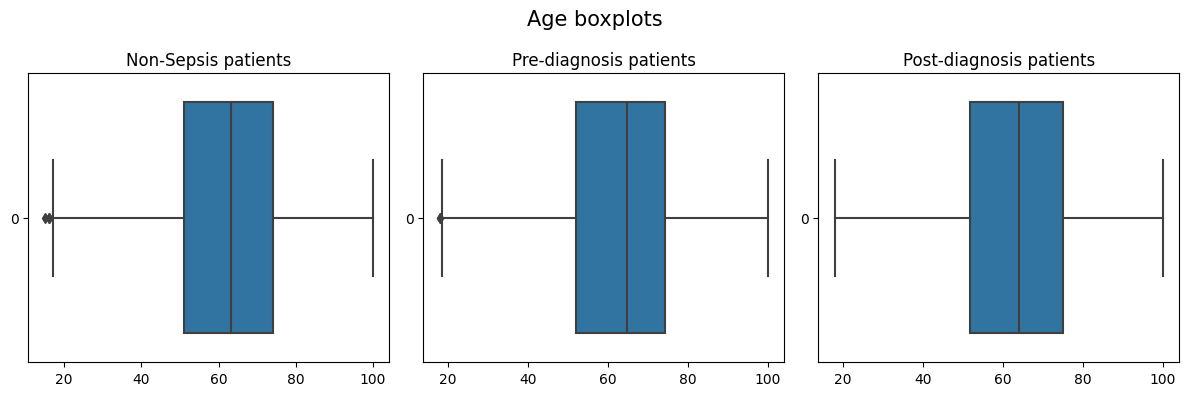

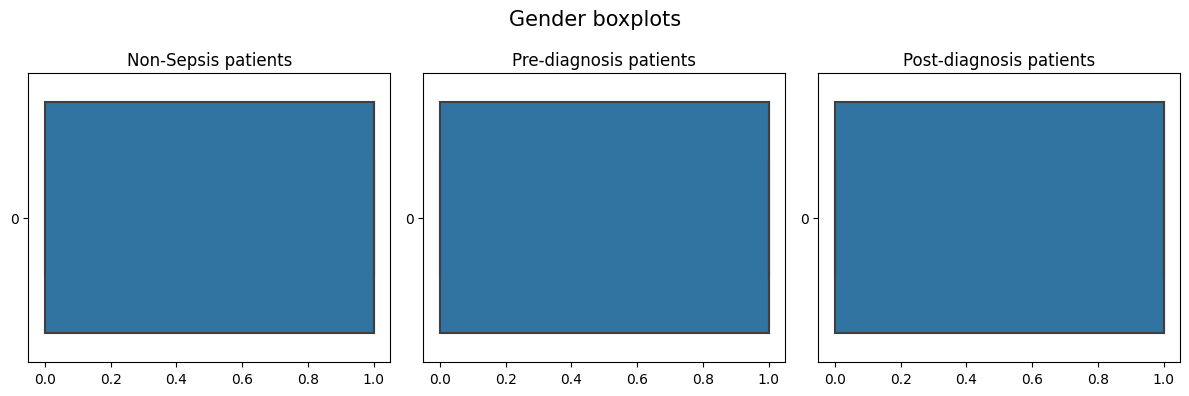

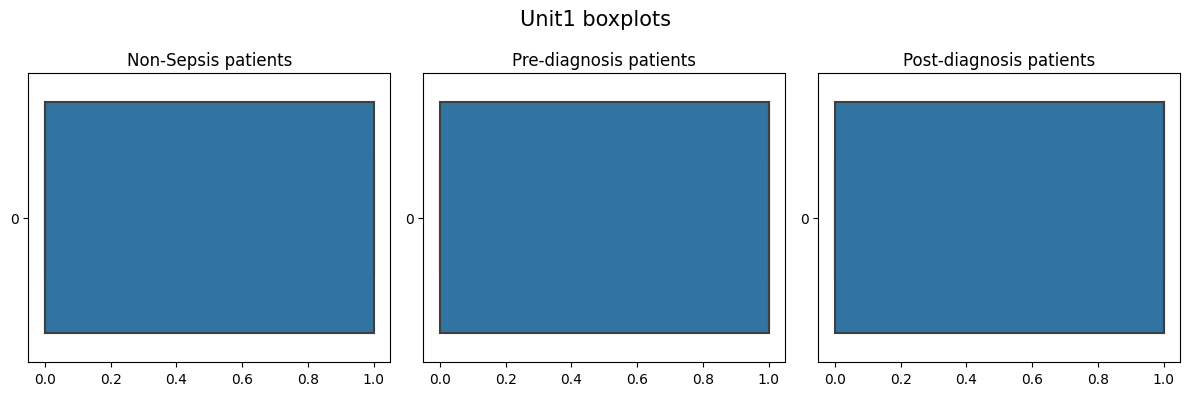

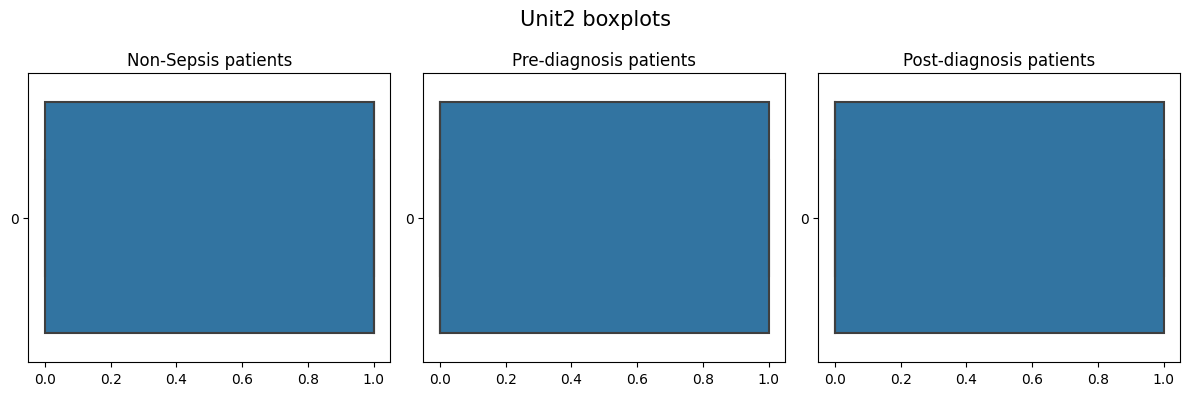

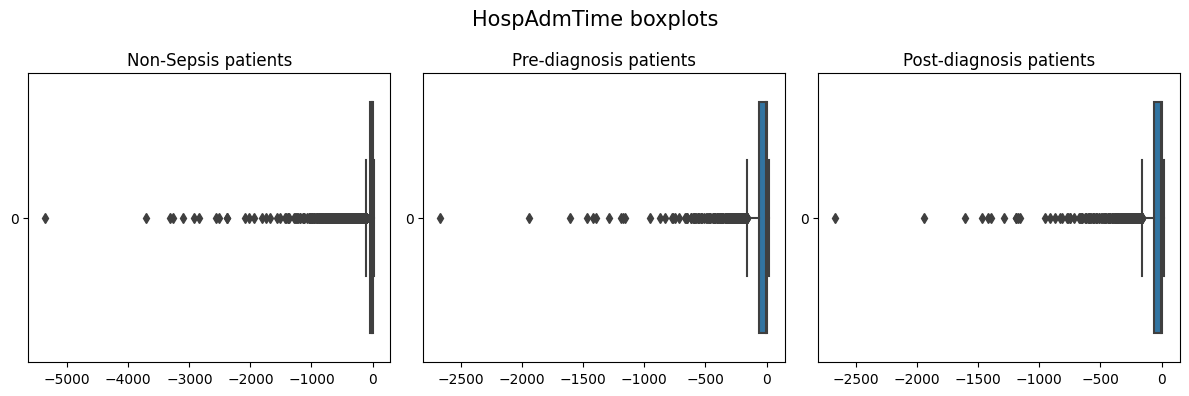

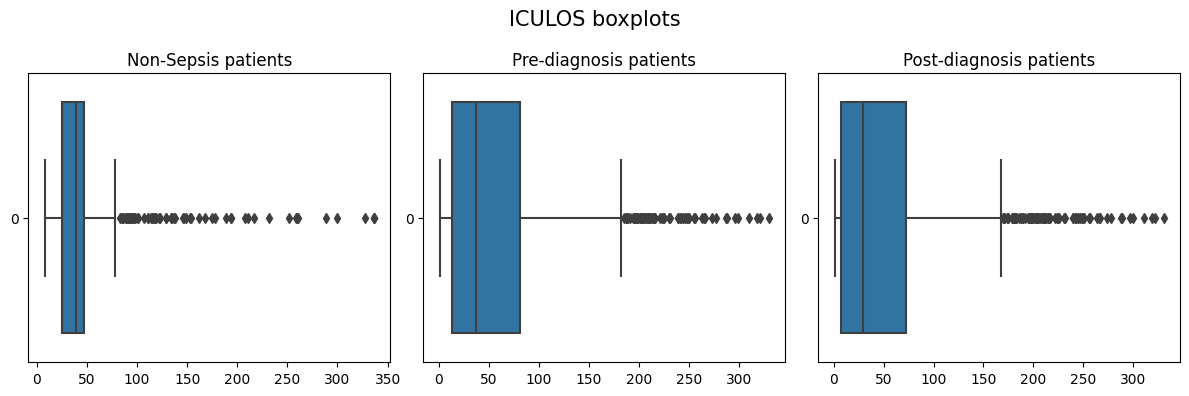

In [9]:
for feature in not_diagnosed_df.columns:
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # Create a figure with 3 subplots
    for df, df_name, i in zip([not_diagnosed_df, diagnosed_zeros, diagnosed_ones], ["Non-Sepsis patients", "Pre-diagnosis patients", "Post-diagnosis patients"], [0, 1, 2]):
        sns.boxplot(data=df[feature], ax=axes[i], orient='h')
        axes[i].set_title(f'{df_name}')
    fig.suptitle(f"{feature} boxplots", fontsize=15)
    plt.tight_layout()
    plt.show()

A quick glance at the tables and the boxplots above reveals that, when splitting the patient into the 3 mentioned groups, there are some differences between the features. For example, we can see that the mean of the `HR` feature tends to be a lot higher for patient who are diagnosed with Sepsis (89.74 before diagnosis and 90.27 after diagnosis) than for those are not suffering from the disease (83.57 at time of release).

In order to check if those differences are statistically significant, we will perform a two-sided T-Test using `scipy`'s `ttest_ind()` function. Note that when performing multiple hypothesis tests, we may make a lot of type-I (Rejecting the null hypothesis when it is correct), also known as [Family-wise error rate](https://en.wikipedia.org/wiki/Family-wise_error_rate). In order to avoid such errors, we use the [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction) to adjust the `alpha` value:

In [10]:
from scipy.stats import ttest_ind
from itertools import combinations

alpha = 0.05 / 3
high_effectiveness_features = []

for feature in not_diagnosed_df.columns:
    test_passes = []
    not_diagnosed_df_col, diagnosed_zeros_col, diagnosed_ones_col = not_diagnosed_df[feature], diagnosed_zeros[feature], diagnosed_ones[feature]
    for feature_pair, pair_names in zip(combinations([not_diagnosed_df_col, diagnosed_zeros_col, diagnosed_ones_col], 2), combinations(["Non-Sepsis patients", "Pre-diagnosis patients", "Post-diagnosis patients"], 2)):
        statistic, pvalue = ttest_ind(feature_pair[0], feature_pair[1], nan_policy='omit', alternative='two-sided')
        print(f"Test on '{feature}' between {pair_names[0]} & {pair_names[1]}: PV={round(pvalue, 3)},", end=' ')
        if pvalue < alpha:
            print("Means are statistically different!")
            test_passes.append(True)
        else:
            print("Means are NOT statistically different!")
            test_passes.append(False)
    print('\n')
    if test_passes[0] and test_passes[1] and not test_passes[2]:
        high_effectiveness_features.append(feature)

# Note that if the means are (statistically) different between non-sepsis & pre-diagnosis AND non-sepsis & post-diagnosis,
# we can assume that the (statistically) different feature we checked may be a good indicator for Sepsis.
print(f"Features that are (probably) a good indicator for Sepsis: \n{high_effectiveness_features}")

Test on 'HR' between Non-Sepsis patients & Pre-diagnosis patients: PV=0.0, Means are statistically different!
Test on 'HR' between Non-Sepsis patients & Post-diagnosis patients: PV=0.0, Means are statistically different!
Test on 'HR' between Pre-diagnosis patients & Post-diagnosis patients: PV=0.502, Means are NOT statistically different!


Test on 'O2Sat' between Non-Sepsis patients & Pre-diagnosis patients: PV=0.008, Means are statistically different!
Test on 'O2Sat' between Non-Sepsis patients & Post-diagnosis patients: PV=0.061, Means are NOT statistically different!
Test on 'O2Sat' between Pre-diagnosis patients & Post-diagnosis patients: PV=0.534, Means are NOT statistically different!


Test on 'Temp' between Non-Sepsis patients & Pre-diagnosis patients: PV=0.0, Means are statistically different!
Test on 'Temp' between Non-Sepsis patients & Post-diagnosis patients: PV=0.0, Means are statistically different!
Test on 'Temp' between Pre-diagnosis patients & Post-diagnosis patients:

In the code cell above, we use a two-sided T-test to check if the mean of each feature is statistically different between every pair of DataFrames: (1) Non-Sepsis patients & Pre-diagnosis patients, (2) Non-Sepsis patients & Post-diagnosis patients, and (3) Pre-diagnosis patients & Post-diagnosis patients.

More specifically, if we find that the means are statistically different when comparing pairs (1) and (2), but not statistically different for pair (3), we can assume that the tested feature can be a good indicator for Sepsis diagnosis.

When using `alpha=0.05 / 3` and comparing the tests results as described in the previous paragraph, we find that the following features are indicative of Sepsis:
`'HR'`, `'Temp'`, `'SBP'`, `'MAP'`, `'DBP'`, `'Resp'`, `'Calcium'`, `'WBC'`, `'Unit1'`, `'Unit2'`, `'HospAdmTime'`.

Next, we plot a heatmap of correlations between the different features in each DataFrame. We will use it to find if there exists a relationship between different pairs of features - to do so, we choose threshold values of `0.85` and `-0.85` - if the correlation between two features is higher/lower than the appropriate threshold, it means that a positive/negative correlation between the features, respectively:

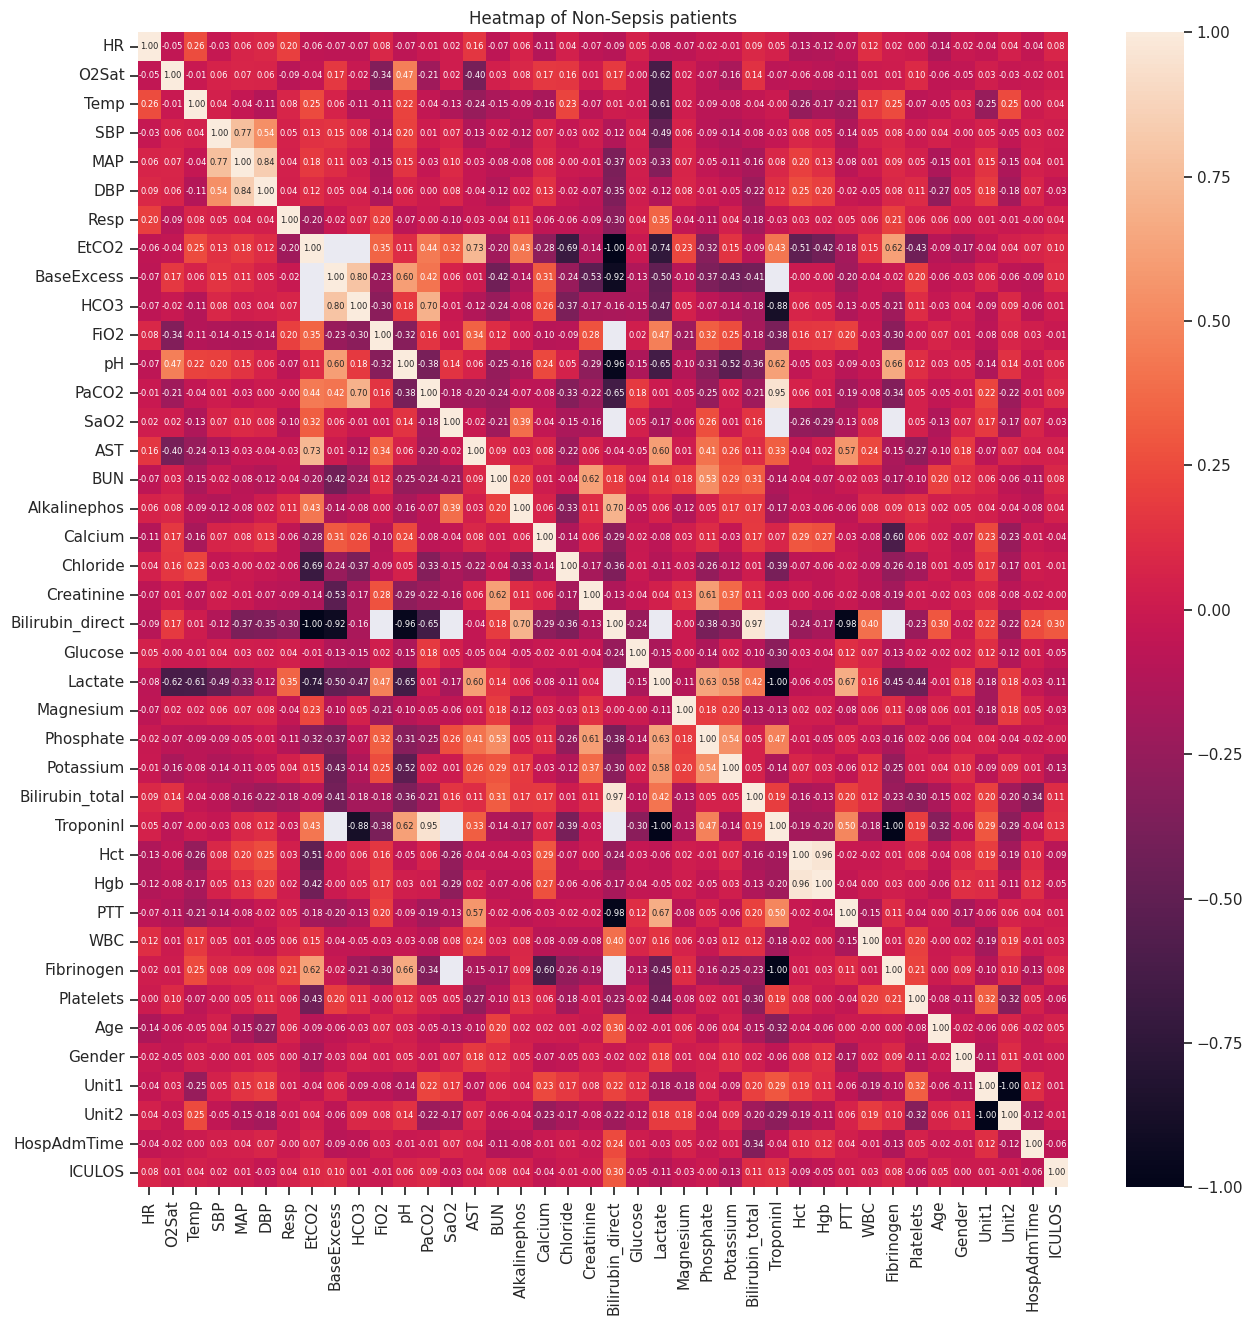

In [11]:
plt.figure(figsize=(15, 15))
sns.set(font_scale=1)
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.title(f"Heatmap of Non-Sepsis patients")
g = sns.heatmap(not_diagnosed_df.corr(), annot=True, cbar=True, fmt=".2f", annot_kws={"fontsize":6})

In [12]:
corr_counter = 0

positively_correlated = []
negatively_correlated = []

for i, row in not_diagnosed_df.corr().iterrows():
    for j, value in row.iteritems():
        if value >= 0.85 and i != j:
            positively_correlated.append(f"{i} & {j}")
            corr_counter += 1
        elif value <= -0.85 and i != j:
            negatively_correlated.append(f"{i} & {j}")
            corr_counter += 1

print(f"Positively correlated features: \n{', '.join(positively_correlated)}")
print(f"\nNegatively correlated features: \n {', '.join(negatively_correlated)}")
print(f"\nTotal of {corr_counter} correlations.")

Positively correlated features: 
PaCO2 & TroponinI, Bilirubin_direct & Bilirubin_total, Bilirubin_total & Bilirubin_direct, TroponinI & PaCO2, Hct & Hgb, Hgb & Hct

Negatively correlated features: 
 EtCO2 & Bilirubin_direct, BaseExcess & Bilirubin_direct, HCO3 & TroponinI, pH & Bilirubin_direct, Bilirubin_direct & EtCO2, Bilirubin_direct & BaseExcess, Bilirubin_direct & pH, Bilirubin_direct & PTT, Lactate & TroponinI, TroponinI & HCO3, TroponinI & Lactate, TroponinI & Fibrinogen, PTT & Bilirubin_direct, Fibrinogen & TroponinI, Unit1 & Unit2, Unit2 & Unit1

Total of 22 correlations.


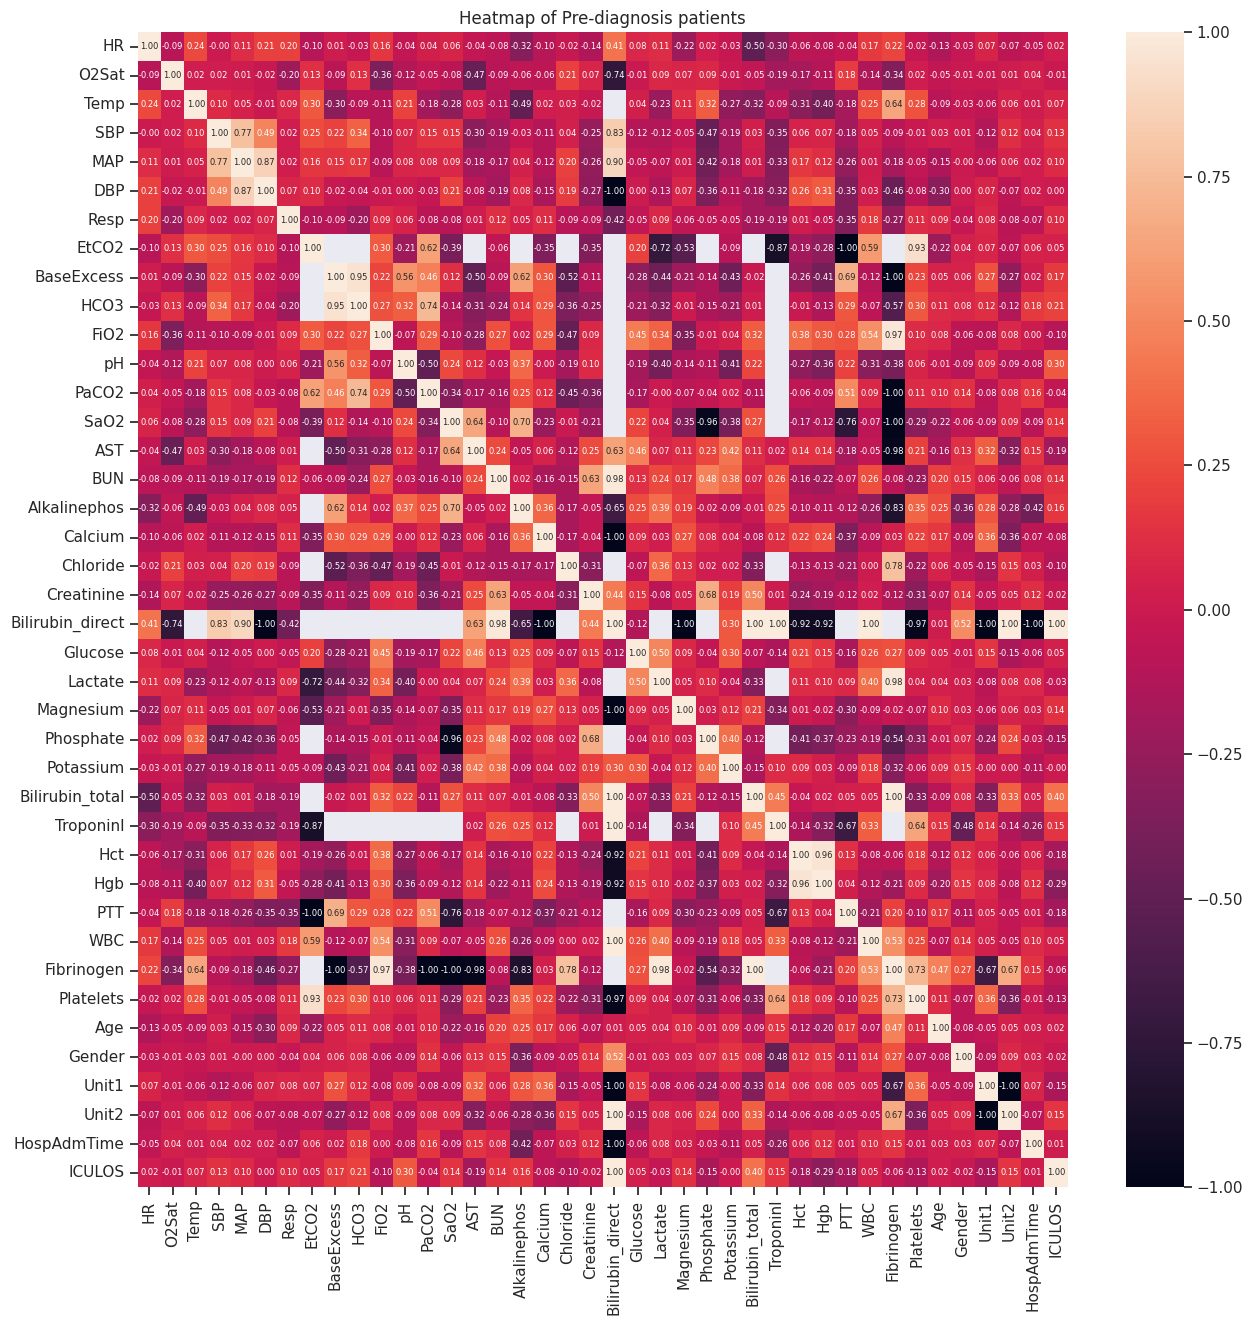

In [13]:
plt.figure(figsize=(15, 15))
sns.set(font_scale=1)
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.title(f"Heatmap of Pre-diagnosis patients")
g = sns.heatmap(diagnosed_zeros.corr(), annot=True, cbar=True, fmt=".2f", annot_kws={"fontsize":6})

In [14]:
corr_counter = 0

positively_correlated = []
negatively_correlated = []

for i, row in diagnosed_zeros.corr().iterrows():
    for j, value in row.iteritems():
        if value >= 0.85 and i != j:
            positively_correlated.append(f"{i} & {j}")
            corr_counter += 1
        elif value <= -0.85 and i != j:
            negatively_correlated.append(f"{i} & {j}")
            corr_counter += 1

print(f"Positively correlated features: \n{', '.join(positively_correlated)}")
print(f"\nNegatively correlated features: \n {', '.join(negatively_correlated)}")
print(f"\nTotal of {corr_counter} correlations.")

Positively correlated features: 
MAP & DBP, MAP & Bilirubin_direct, DBP & MAP, EtCO2 & Platelets, BaseExcess & HCO3, HCO3 & BaseExcess, FiO2 & Fibrinogen, BUN & Bilirubin_direct, Bilirubin_direct & MAP, Bilirubin_direct & BUN, Bilirubin_direct & Bilirubin_total, Bilirubin_direct & TroponinI, Bilirubin_direct & WBC, Bilirubin_direct & Unit2, Bilirubin_direct & ICULOS, Lactate & Fibrinogen, Bilirubin_total & Bilirubin_direct, Bilirubin_total & Fibrinogen, TroponinI & Bilirubin_direct, Hct & Hgb, Hgb & Hct, WBC & Bilirubin_direct, Fibrinogen & FiO2, Fibrinogen & Lactate, Fibrinogen & Bilirubin_total, Platelets & EtCO2, Unit2 & Bilirubin_direct, ICULOS & Bilirubin_direct

Negatively correlated features: 
 DBP & Bilirubin_direct, EtCO2 & TroponinI, EtCO2 & PTT, BaseExcess & Fibrinogen, PaCO2 & Fibrinogen, SaO2 & Phosphate, SaO2 & Fibrinogen, AST & Fibrinogen, Calcium & Bilirubin_direct, Bilirubin_direct & DBP, Bilirubin_direct & Calcium, Bilirubin_direct & Magnesium, Bilirubin_direct & Hct,

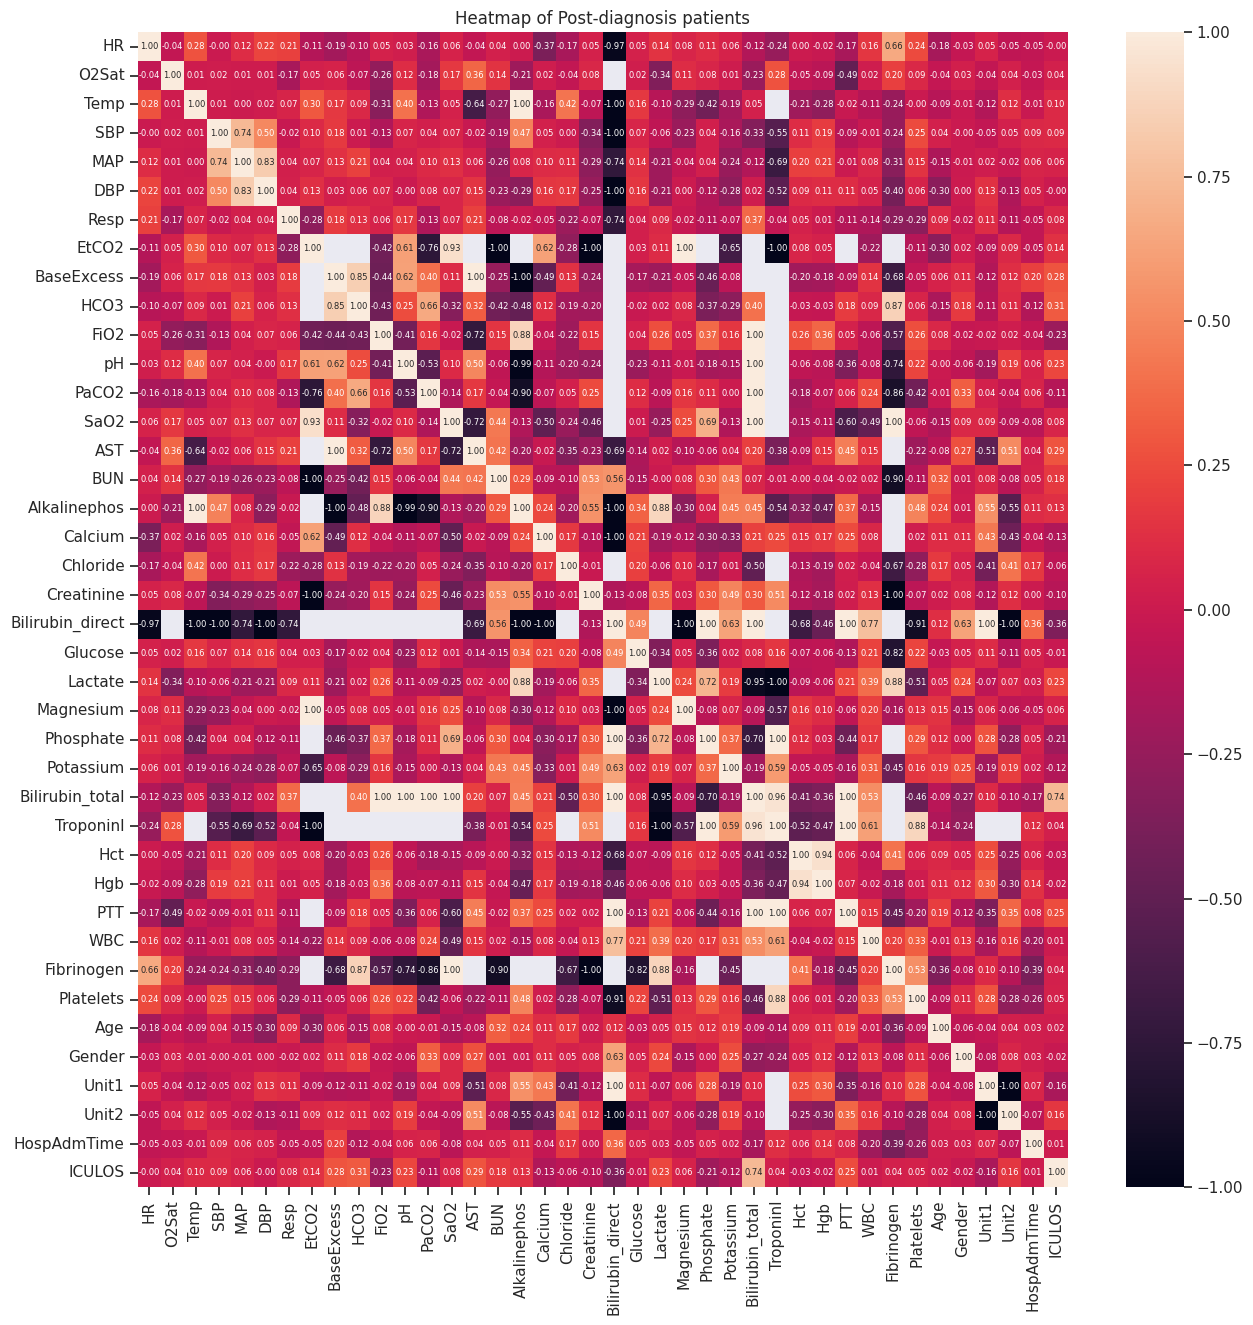

In [15]:
plt.figure(figsize=(15, 15))
sns.set(font_scale=1)
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.title(f"Heatmap of Post-diagnosis patients")
g = sns.heatmap(diagnosed_ones.corr(), annot=True, cbar=True, fmt=".2f", annot_kws={"fontsize":6})

In [16]:
corr_counter = 0

positively_correlated = []
negatively_correlated = []

for i, row in diagnosed_ones.corr().iterrows():
    for j, value in row.iteritems():
        if value >= 0.85 and i != j:
            positively_correlated.append(f"{i} & {j}")
            corr_counter += 1
        elif value <= -0.85 and i != j:
            negatively_correlated.append(f"{i} & {j}")
            corr_counter += 1

print(f"Positively correlated features: \n{', '.join(positively_correlated)}")
print(f"\nNegatively correlated features: \n {', '.join(negatively_correlated)}")
print(f"\nTotal of {corr_counter} correlations.")

Positively correlated features: 
Temp & Alkalinephos, EtCO2 & SaO2, EtCO2 & Magnesium, BaseExcess & AST, HCO3 & Fibrinogen, FiO2 & Alkalinephos, FiO2 & Bilirubin_total, pH & Bilirubin_total, PaCO2 & Bilirubin_total, SaO2 & EtCO2, SaO2 & Bilirubin_total, SaO2 & Fibrinogen, AST & BaseExcess, Alkalinephos & Temp, Alkalinephos & FiO2, Alkalinephos & Lactate, Bilirubin_direct & Phosphate, Bilirubin_direct & Bilirubin_total, Bilirubin_direct & PTT, Bilirubin_direct & Unit1, Lactate & Alkalinephos, Lactate & Fibrinogen, Magnesium & EtCO2, Phosphate & Bilirubin_direct, Phosphate & TroponinI, Bilirubin_total & FiO2, Bilirubin_total & pH, Bilirubin_total & PaCO2, Bilirubin_total & SaO2, Bilirubin_total & Bilirubin_direct, Bilirubin_total & TroponinI, Bilirubin_total & PTT, TroponinI & Phosphate, TroponinI & Bilirubin_total, TroponinI & PTT, TroponinI & Platelets, Hct & Hgb, Hgb & Hct, PTT & Bilirubin_direct, PTT & Bilirubin_total, PTT & TroponinI, Fibrinogen & HCO3, Fibrinogen & SaO2, Fibrinogen

When a patient is not suffering from Sepsis, it has less correlated features than a patient before/after being diagnosed with Sepsis. Also, diagnosis of Sepsis reveals even more correlations than pre-diagnosis.

Next, we plot the distribution of each of the features:

In [17]:
full_data = pd.concat(data)  # Full data from the entire 20,000 DFs

41it [05:06,  7.48s/it]


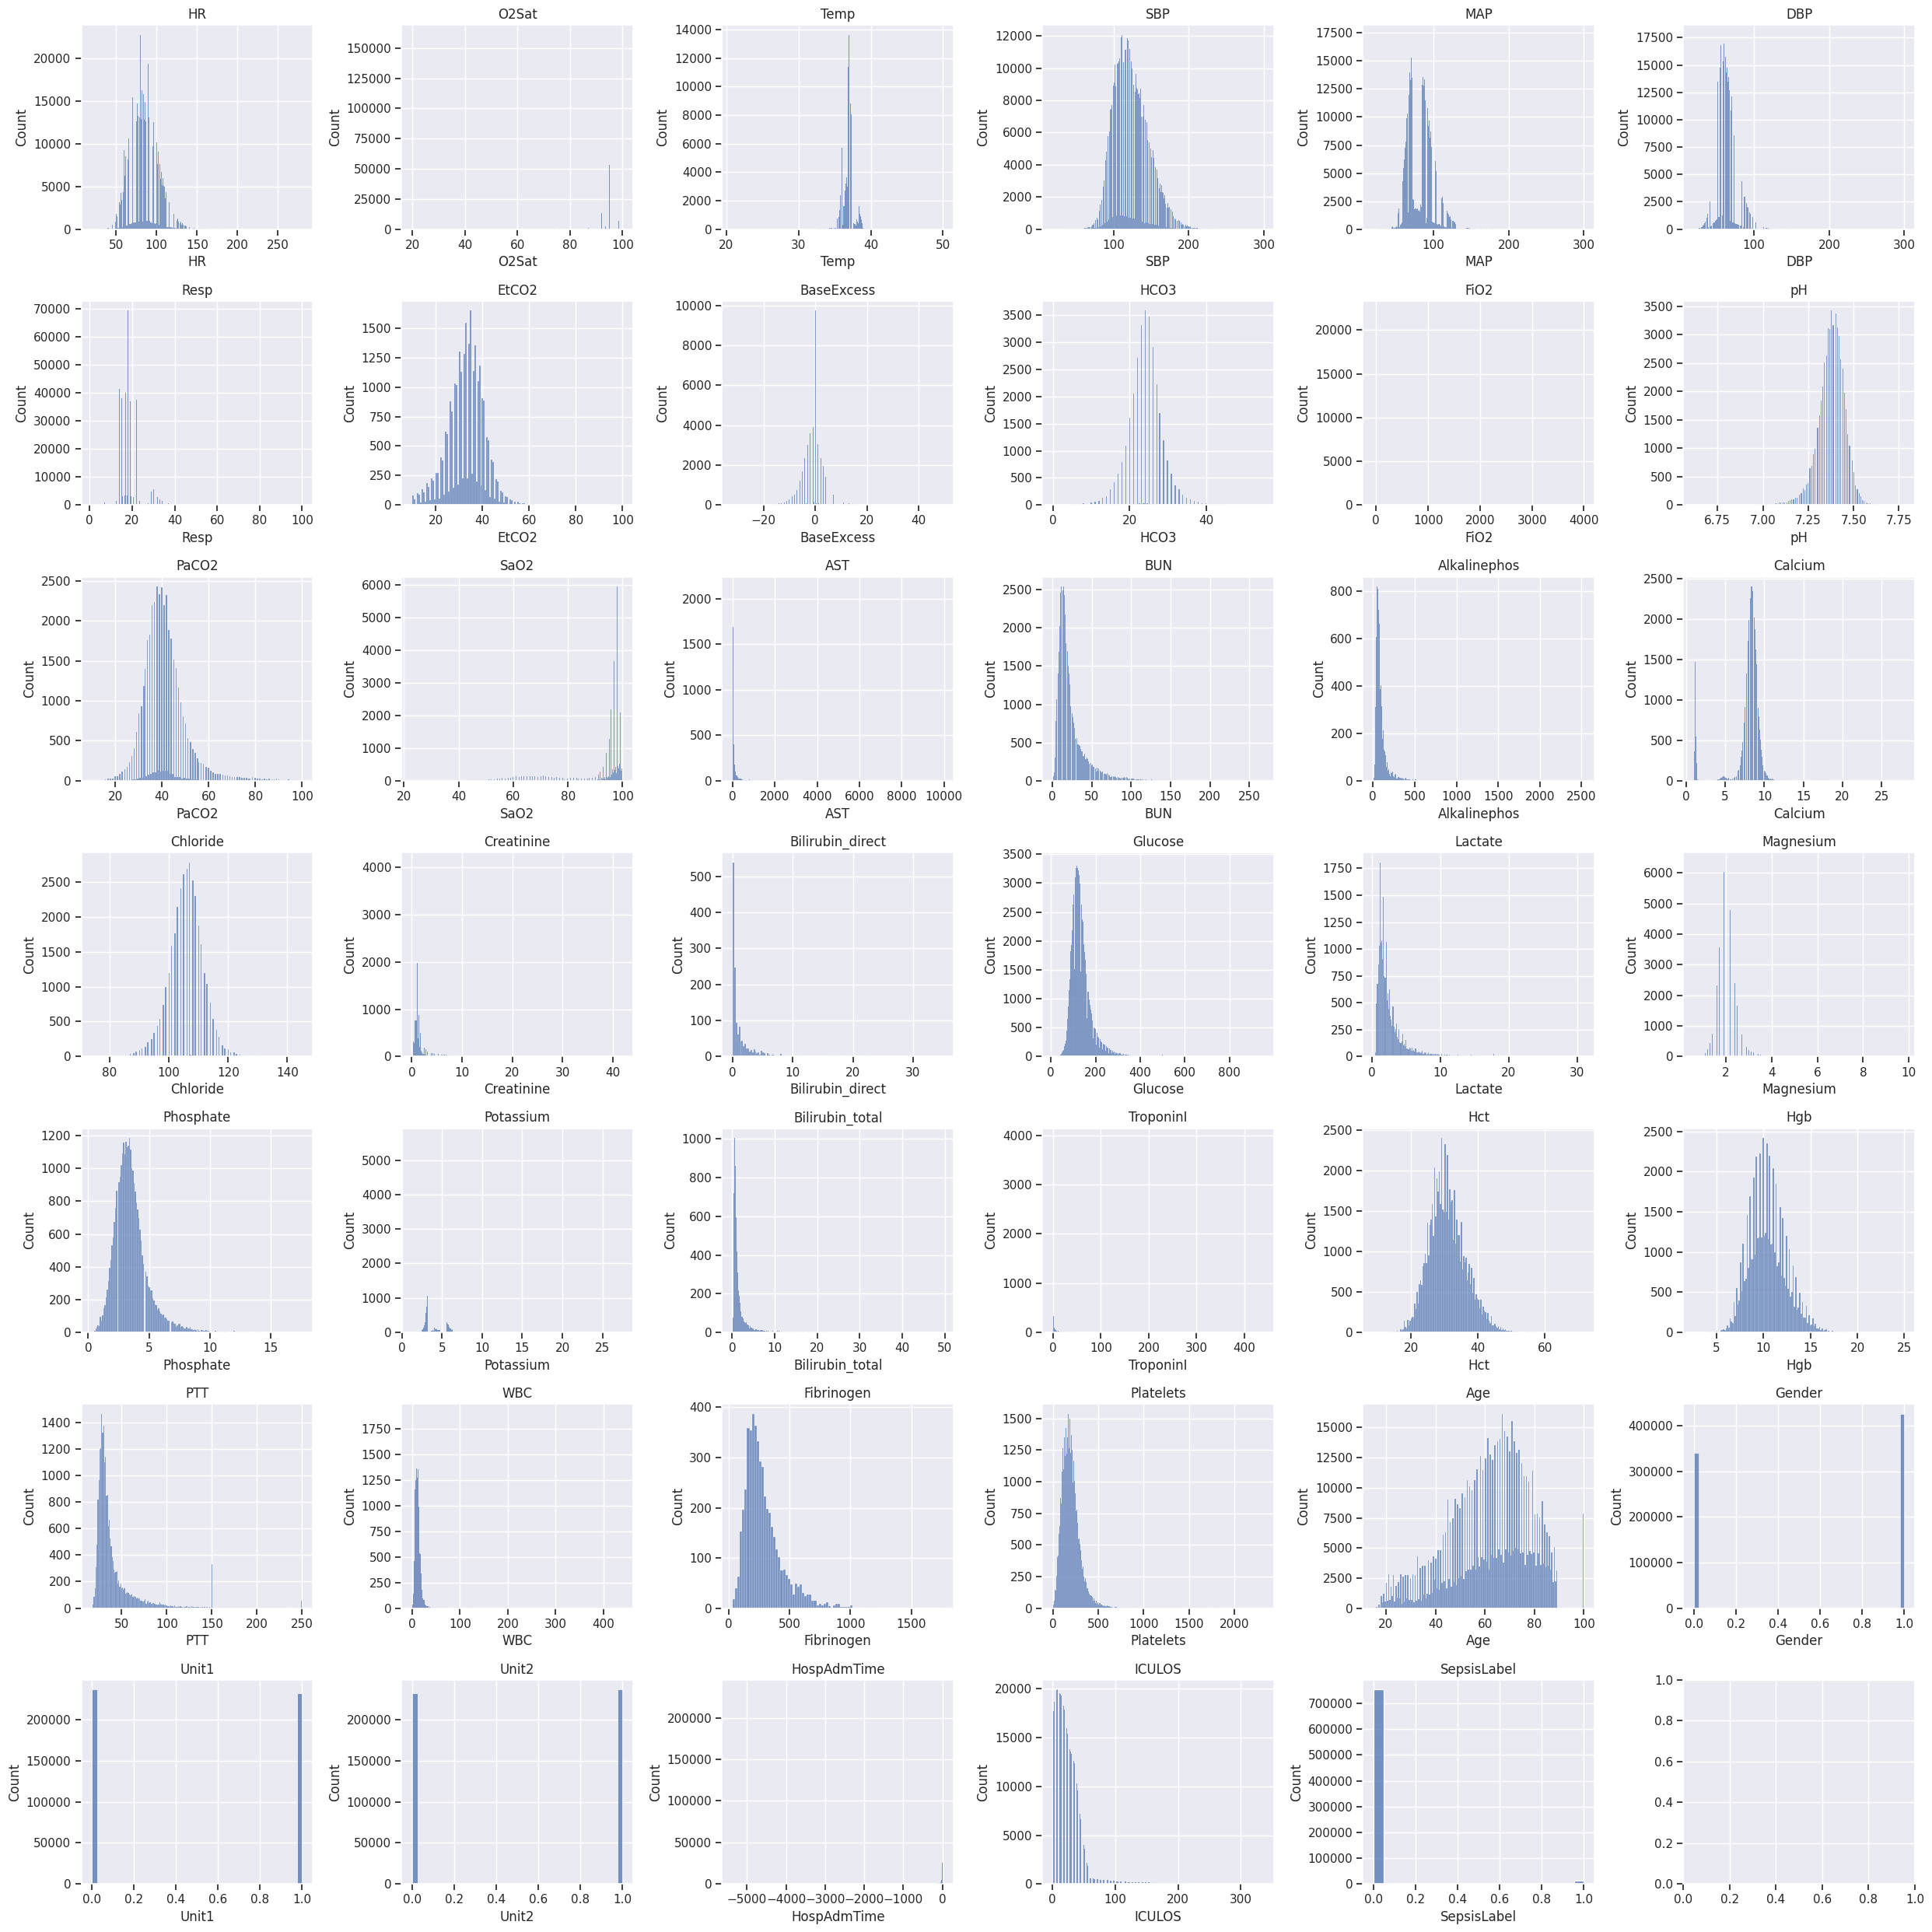

In [18]:
num_rows, num_cols = 7, 6

# Create the subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(25, 25))

axes = axes.flatten()  # Flatten the axes array

for i, col in tqdm(enumerate(full_data.columns)):
    ax = axes[i]
    sns.histplot(data=full_data[col], ax=ax)
    ax.set_title(f'{col}')

# Hide unused subplots
if len(data) < len(axes):
    for j in range(len(data), len(axes)):
        axes[j].axis('off')

plt.tight_layout()
plt.show()

By observing the above histograms, we can see that there are many missing values (for example, the jittering in the `Age` and `Hgb` histograms suggests that this is the case). These will be dealt with later on when we preprocess the data before applying different models on it.

Finally, we compare the distributions of the features in the 3 DataFrames created. We can check if two samples have the same distribution using the [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test): The null hypothesis is that both samples were drawn from the same distribution.

In [19]:
from scipy.stats import ks_2samp

alpha = 0.05 / 3
feature_dists = {col: [] for col in data[0].columns}

for dfs_pair, dfs_names in zip(combinations([not_diagnosed_df, diagnosed_zeros, diagnosed_ones], 2), combinations(["Non-Sepsis patients", "Pre-diagnosis patients", "Post-diagnosis patients"], 2)):
    for feature in not_diagnosed_df.columns:
        is_same_flag = 0
        statistic, pvalue = ks_2samp(dfs_pair[0][feature], dfs_pair[1][feature])
        if pvalue < alpha:  # Feature is NOT drawn from the same distribution in both samples
            is_same_flag = 0
        else:  # Feature is drawn from the same distribution in both samples
            is_same_flag = 1
        feature_dists[feature].append(is_same_flag)

print_counter = 0
for key, val in feature_dists.items():
    if val in ([0, 0, 1], [0, 1, 1], [1, 0, 1]):  # In any of these cases, the distribution between non-Sepsis and Sepsis is different
        print(f"Sepsis changes the distribution of {key}.")
        print_counter += 1

if not print_counter:
    print("Sepsis diagnosis does not change the distribution of any of the features.")

Sepsis changes the distribution of EtCO2.
Sepsis changes the distribution of BaseExcess.
Sepsis changes the distribution of FiO2.
Sepsis changes the distribution of pH.
Sepsis changes the distribution of PaCO2.
Sepsis changes the distribution of BUN.
Sepsis changes the distribution of Glucose.
Sepsis changes the distribution of Potassium.
Sepsis changes the distribution of Hct.
Sepsis changes the distribution of Hgb.
Sepsis changes the distribution of Unit1.
Sepsis changes the distribution of Unit2.
Sepsis changes the distribution of HospAdmTime.


The above result suggests that Sepsis changes the distribution of some of the given features (with confidence level of `alpha = 0.05 / 3`. Some of these features also appeared to have different means in the T-test section above.